In [1]:
%load_ext autoreload
%autoreload 2

from circuit_breaking.src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from circuit_breaking.src.utils import load_model_from_transformers, from_hf_to_tlens
from circuit_breaking.src.masks import MLPHiddenMask
from tqdm.auto import tqdm
#torch.autograd.set_detect_anomaly(True) 


In [2]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
model_name_or_path = "google/gemma-7b"
model_type = "gemma"

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained("google/gemma-7b", torch_dtype=torch.bfloat16)
n_layers = 28
n_heads = 16

print(torch.cuda.memory_allocated() / 1024**3)

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

0.0


In [3]:
from tasks import PileTask, OWTTask, InductionTask, GreaterThanTask
from tasks.ioi.IOITask import IOITask, IOITask_NPO, IOITask_Uniform
from tasks.induction.InductionTask import InductionTask, InductionTask_NPO, InductionTask_Uniform
from tasks.facts.SportsTask import SportsTask, SportsTask_NPO, SportsTask_Uniform
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval
from tasks.facts.SportsTaskSideEffects import run_side_effects_evals


train_batch_size = 4
eval_batch_size=32

device = "cuda"
train_loss_type = "sports"

maintain_sport = None


# forget_sport=None
# forget_athletes = 16
# save_dir = f"results/localized_finetuning_{forget_athletes}_athletes"
# forget_kwargs = {"forget_player_subset": forget_athletes, "is_forget_dataset": True, "train_test_split": False}
# maintain_kwargs = {"forget_player_subset": forget_athletes, "is_forget_dataset": False, "train_test_split": True}# 
# forget_loss_coef = 1

forget_sport="basketball"
forget_athletes = None
save_dir = f"results/localized_finetuning_{forget_sport}"
forget_kwargs = {"forget_sport_subset": {forget_sport}, "is_forget_dataset": True, "train_test_split": True}
maintain_kwargs = {"forget_sport_subset": {forget_sport}, "is_forget_dataset": False, "train_test_split": True}
forget_loss_coef=.2

os.makedirs(save_dir, exist_ok=True)


sports_1mp = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="log_1_minus_p", **forget_kwargs)

if maintain_sport is None:
    maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **maintain_kwargs)
else:
    maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **maintain_kwargs)

train_pile = PileTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, ctx_length=100, shuffle=True, buffer_size=50000)
train_tasks = {"sports_1mp": (sports_1mp, forget_loss_coef), "maintain_sports": (maintain_sports, 1), "pile": (train_pile, 1)}

# want to eval on other sports
forget_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **forget_kwargs)
test_pile = PileTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, ctx_length=100, shuffle=True, buffer_size=50000)

induction_eval = InductionTask(batch_size=eval_batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device)
if maintain_sport is None:
    maintain_sports_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **maintain_kwargs)
    eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": forget_sport_eval, "maintain_sport": maintain_sports_eval}
else:
    maintain_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={maintain_sport}, is_forget_dataset=True)
    val_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={val_sport}, is_forget_dataset=True)
    eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": forget_sport_eval, "maintain_sport": maintain_sport_eval, "val_sport": val_sport_eval}


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


In [4]:
from cb_utils.mask_utils import convert_attrs_to_components, get_top_components, get_top_components_no_subcomponents, get_random_components, load_mask_from_state_dict, get_parameter, apply_localized_gradients

import pickle
with open("models/google_gemma-7b_sports_all_ap_graph.pkl", "rb") as f:
    ap_graph = pickle.load(f)
print(ap_graph.keys())

# ct components
with open("models/google_gemma-7b_sports_all_ct_graph.pkl", "rb") as f:
    ct_graph = pickle.load(f)
print(ct_graph)

beta = 3
top_p = 5
combine_heads = True

localization_types = ["localized_ap", "localized_ct", "random", "manual_interp", "nonlocalized"]
# localization_types = ["nonlocalized"]
# localization_types = ["manual_interp"]

all_components = {}

for localization_type in localization_types:
    if localization_type == 'localized_ap':
        final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, n_heads=n_heads, n_layers=n_layers, combine_heads=combine_heads), n_heads=n_heads, top_p=top_p)

    elif localization_type == 'localized_ct':
        final_components, final_attn_heads = get_top_components_no_subcomponents(ct_graph, n_heads=n_heads, n_layers=n_layers, top_p=top_p, combine_heads=combine_heads)

    elif localization_type == 'manual_interp':
        final_components = []
        for mlp_layer in range(2, 8):
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_pre")
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_post")
        final_attn_heads = {}
        # mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

    elif localization_type == 'random':
        final_components, final_attn_heads = get_random_components(n_layers=n_layers, n_heads=n_heads, top_p=top_p, combine_subcomponents=False)

    elif localization_type == 'nonlocalized':
        final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, n_heads=n_heads, n_layers=n_layers, combine_heads=combine_heads), n_heads=n_heads, top_p=100)
        assert (torch.tensor([len(x) for x in final_attn_heads.values()]) == n_heads).all()

    all_components[localization_type] = (final_components, final_attn_heads)


model_init_funcs = {}

def init_model_func(localization_type):
    def get_model_fn():
        model = AutoModelForCausalLM.from_pretrained("google/gemma-7b", torch_dtype=torch.bfloat16)
        apply_localized_gradients(model, all_components[localization_type][0])
        return model
    return get_model_fn
for localization_type in localization_types:
    model_init_funcs[localization_type] = init_model_func(localization_type)

dict_keys(['a0.0_q', 'a0.1_q', 'a0.2_q', 'a0.3_q', 'a0.4_q', 'a0.5_q', 'a0.6_q', 'a0.7_q', 'a0.8_q', 'a0.9_q', 'a0.10_q', 'a0.11_q', 'a0.12_q', 'a0.13_q', 'a0.14_q', 'a0.15_q', 'a0.0_k', 'a0.1_k', 'a0.2_k', 'a0.3_k', 'a0.4_k', 'a0.5_k', 'a0.6_k', 'a0.7_k', 'a0.8_k', 'a0.9_k', 'a0.10_k', 'a0.11_k', 'a0.12_k', 'a0.13_k', 'a0.14_k', 'a0.15_k', 'a0.0_v', 'a0.1_v', 'a0.2_v', 'a0.3_v', 'a0.4_v', 'a0.5_v', 'a0.6_v', 'a0.7_v', 'a0.8_v', 'a0.9_v', 'a0.10_v', 'a0.11_v', 'a0.12_v', 'a0.13_v', 'a0.14_v', 'a0.15_v', 'a0.0_result', 'a0.1_result', 'a0.2_result', 'a0.3_result', 'a0.4_result', 'a0.5_result', 'a0.6_result', 'a0.7_result', 'a0.8_result', 'a0.9_result', 'a0.10_result', 'a0.11_result', 'a0.12_result', 'a0.13_result', 'a0.14_result', 'a0.15_result', 'a1.0_q', 'a1.1_q', 'a1.2_q', 'a1.3_q', 'a1.4_q', 'a1.5_q', 'a1.6_q', 'a1.7_q', 'a1.8_q', 'a1.9_q', 'a1.10_q', 'a1.11_q', 'a1.12_q', 'a1.13_q', 'a1.14_q', 'a1.15_q', 'a1.0_k', 'a1.1_k', 'a1.2_k', 'a1.3_k', 'a1.4_k', 'a1.5_k', 'a1.6_k', 'a1.7_k',

## Train Masks

In [5]:
torch.cuda.memory_allocated() // 1024**3
del model

In [6]:
from collections import defaultdict
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval_redo

combine_heads = False
top_p = 5
# learning_rate = 1e-2
# n_epochs = 100
# grad_accum_steps = 16
learning_rate = 2e-5
n_epochs = 25
grad_accum_steps = 64 // train_batch_size
# max_gpu_batch_size=8
beta = 3
clip_grad = 1

evaluate_every = 1
n_eval_iters = 5
deep_evaluate_every = 1
do_adversarial_evals = True
do_side_effects_evals = True

use_wandb = True

import wandb

for localization_type in localization_types:
# for localization_type in ["nonlocalized"]:
    print(f"Memory at start for {localization_type}: {torch.cuda.memory_allocated() / 1024**3}")
    if use_wandb:
        wandb.init(project="circuit_breaking", name=f"finetuning_{localization_type}_{forget_sport=}_{forget_athletes=}")
        wandb.config.update({"model_type": model_type, "localization_type": localization_type, "combine_heads": combine_heads, "beta": beta, "forget_sport": forget_sport, "forget_athletes": forget_athletes, "lr": learning_rate, "n_epochs": n_epochs, "grad_accum_steps": grad_accum_steps, "forget_loss_coef": forget_loss_coef, "clip_grad": clip_grad})

    model = model_init_funcs[localization_type]()
    model.cuda()

    all_train_losses = defaultdict(list)
    all_test_losses = defaultdict(list)
    adversarial_evals = []
    side_effect_evals = []

    # Initialize optimizer

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_epochs)
    # Cycle dataloaders
    # Train a sparse mask
    # print(f"Memory afterloading {localization_type} model: {torch.cuda.memory_allocated() / 1024**3}")


    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        # Sample batches
        # Reset grad
        optimizer.zero_grad()
        # Compute normal loss over retain
        for task_name, (task, task_weight) in train_tasks.items():
            task_loss = 0
            for i in range(grad_accum_steps):
                loss = task.get_train_loss(model) / grad_accum_steps
                task_loss += loss.item()
                loss *= task_weight
                loss.backward()
            all_train_losses[task_name].append(task_loss)
            if use_wandb:
                wandb.log({f"{task_name}_train_loss": task_loss}, step=epoch)
            
        # print(f"Before backpropgating loss on epoch {epoch}: {torch.cuda.memory_allocated() / 1024**3}, max mem: {torch.cuda.max_memory_allocated() / 1024**3}")
        # Step and log
        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        # zero_nan_grads(mask)
        optimizer.step()
        scheduler.step()

        # print(f"After backpropgating loss on epoch {epoch}: {torch.cuda.memory_allocated() / 1024**3}, max mem: {torch.cuda.max_memory_allocated() / 1024**3}")


        if epoch % evaluate_every == 0 or epoch == n_epochs - 1:
            for task_name, task in eval_tasks.items():
                task_loss = 0
                task_accuracy = 0
                for i in range(n_eval_iters):
                    task_loss += task.get_test_loss(model).item()
                    task_accuracy += task.get_test_accuracy(model)
                all_test_losses[task_name].append(task_loss / n_eval_iters)
                if use_wandb:
                    wandb.log({f"{task_name}_test_loss": task_loss / n_eval_iters}, step=epoch)
                    wandb.log({f"{task_name}_test_accuracy": task_accuracy / n_eval_iters}, step=epoch)

        # print(f"After evaluating test loss on epoch {epoch}: {torch.cuda.memory_allocated() / 1024**3}, max mem: {torch.cuda.max_memory_allocated() / 1024**3}")


        if epoch % deep_evaluate_every == 0 or epoch == n_epochs - 1:
            if do_adversarial_evals:
                print("Running adversarial evals")
                adv_evals = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, 
                    forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|forget_kwargs, 
                    maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|maintain_kwargs, 
                    continuous=True, include_evals=["Normal", "MC"])
                adversarial_evals.append(adv_evals)
                if use_wandb:
                    wandb.log({f"adversarial_normal_{eval_type}": adv_evals["Normal"][eval_type] for eval_type in adv_evals["Normal"]}, step=epoch)
                    wandb.log({f"adversarial_mc_{eval_type}": adv_evals["MC"][eval_type] for eval_type in adv_evals["MC"]}, step=epoch)
            # print(f"After evaluating adversarial evals on epoch {epoch}: {torch.cuda.memory_allocated() / 1024**3}, max mem: {torch.cuda.max_memory_allocated() / 1024**3}")
            if do_side_effects_evals:
                print("Running side effects evals")
                side_effect_evals.append(run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["General"], general_batch_size=5))
                if use_wandb:
                    wandb.log(side_effect_evals[-1]["General"], step=epoch)
            # print(f"After evaluating side effects evals on epoch {epoch}: {torch.cuda.memory_allocated() / 1024**3}, max mem: {torch.cuda.max_memory_allocated() / 1024**3}")

    
    os.makedirs(f"{save_dir}/models", exist_ok=True)
    torch.save(model.state_dict(), f"{save_dir}/models/{model_type}_{localization_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt")

    with open(f"{save_dir}/models/{model_type}_{localization_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}_metrics.pkl", "wb") as f:
        pickle.dump({"train_losses": all_train_losses, "test_losses": all_test_losses, "adversarial_evals": adversarial_evals, "side_effect_evals": side_effect_evals}, f)
    
    model.cpu()
    del model
    if use_wandb:
        wandb.finish()

Memory at start for nonlocalized: 0.0


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: philliphguo (quirky_lats_at_mats). Use `wandb login --relogin` to force relogin


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting blocks.0.attn.hook_q to True
Setting blocks.0.attn.hook_k to True
Setting blocks.0.attn.hook_v to True
Ignoring blocks.0.attn.hook_result
Could not find parameter for blocks.0.attn.hook_result
Setting blocks.0.mlp.hook_pre to True
Setting blocks.0.mlp.hook_post to True
Setting blocks.1.attn.hook_q to True
Setting blocks.1.attn.hook_k to True
Setting blocks.1.attn.hook_v to True
Ignoring blocks.1.attn.hook_result
Could not find parameter for blocks.1.attn.hook_result
Setting blocks.1.mlp.hook_pre to True
Setting blocks.1.mlp.hook_post to True
Setting blocks.2.attn.hook_q to True
Setting blocks.2.attn.hook_k to True
Setting blocks.2.attn.hook_v to True
Ignoring blocks.2.attn.hook_result
Could not find parameter for blocks.2.attn.hook_result
Setting blocks.2.mlp.hook_pre to True
Setting blocks.2.mlp.hook_post to True
Setting blocks.3.attn.hook_q to True
Setting blocks.3.attn.hook_k to True
Setting blocks.3.attn.hook_v to True
Ignoring blocks.3.attn.hook_result
Could not find param

  0%|          | 0/25 [00:00<?, ?it/s]

Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MMLU,█▁█▇▄▄▄▄▄▃▄▄▄▃▄▄▄▅▄▄▄▃▃▄▅
adversarial_mc_forget,▃▃▃▁▂▃▆▅▅▆▇████████▇█▇▇█▇
adversarial_mc_maintain,▆▅██▇▅▃▄▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▂▂
adversarial_normal_forget,▄▁▁▁▂▁▁▁▁▁▂▂▂▄██▆▅▄▃▃▃▃▃▃
adversarial_normal_maintain,▃▇▃▁▇██▄▇▄▂▂▂▄▃▄▄▂▂▅▁▇▅▂▄
forget_sport_test_accuracy,▂▁▁▁▁▁▁▁▁▄▅▆▆█▅▄▃▃▃▃▃▃▃▃▃
forget_sport_test_loss,▂▃▅██▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
induction_test_accuracy,█▁▇▇▆▅▄▄▅▃▄▅▅▆▆▆▆▇▆▇▆▇▆▇▇
induction_test_loss,▁█▂▂▂▃▅▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂
maintain_sport_test_accuracy,▆▆▂▃▄█▄▆▃▅▆█▄▅▁▅▆▅▄▄▅▆▅▅▄
maintain_sport_test_loss,▂▁▅█▇▃▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


## Analyze Mask

In [6]:
from cb_utils.mask_utils import convert_attrs_to_components, get_top_components, get_top_components_no_subcomponents, get_random_components, load_mask_from_state_dict

import pickle
with open("models/google_gemma-7b_sports_all_ap_graph.pkl", "rb") as f:
    ap_graph = pickle.load(f)
print(ap_graph.keys())

# ct components
with open("models/google_gemma-7b_sports_all_ct_graph.pkl", "rb") as f:
    ct_graph = pickle.load(f)
print(ct_graph)
model.cuda()

beta = 3
top_p = 5
combine_heads = False

save_dir = "results/neuron_cb_unlearn_athletes_2"
mask_paths = {
    "localized_ap": f"{save_dir}/masks/gemma_localized_ap_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt", 
        "localized_ct": f"{save_dir}/masks/{model_type}_localized_ct_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt",
        "random": f"{save_dir}/masks/{model_type}_random_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt",
         "manual_interp": f"{save_dir}/masks/gemma_manual_interp_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt",
         "nonlocalized": f"{save_dir}/masks/gemma_nonlocalized_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt"
         }

# masks = {}
# models = {}

all_components = {}
for mask_type, mask_path in mask_paths.items():
    if mask_type == 'localized_ap':
        final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, n_heads=model.cfg.n_heads, n_layers=model.cfg.n_layers, combine_heads=combine_heads), n_heads=model.cfg.n_heads, top_p=top_p)

    elif mask_type == 'localized_ct':
        final_components, final_attn_heads = get_top_components_no_subcomponents(ct_graph, n_heads=model.cfg.n_heads, n_layers=model.cfg.n_layers, top_p=top_p, combine_heads=combine_heads)

    elif mask_type == 'manual_interp':
        final_components = []
        for mlp_layer in range(1, 8):
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_pre")
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_post")
        final_attn_heads = {}
        # mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

    elif mask_type == 'random':
        from circuit_breaking.src.masks import convert_param_name
        state_dict = torch.load(mask_path)
        final_components = []
        final_attn_heads = defaultdict(list)
        for key in state_dict.keys():
            if "masks.blocks" not in key:
                continue
            component_name = convert_param_name(key, inverse=True)
            # cut off "masks."
            component_name = component_name[6:]
            final_components.append(component_name)
            if "attn" in component_name:
                final_attn_heads[component_name] = list(range(model.cfg.n_heads))

    elif mask_type == 'nonlocalized':
        final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, n_heads=model.cfg.n_heads, n_layers=model.cfg.n_layers, combine_heads=combine_heads), n_heads=model.cfg.n_heads, top_p=100)
        assert (torch.tensor([len(x) for x in final_attn_heads.values()]) == model.cfg.n_heads).all()

    all_components[mask_type] = (final_components, final_attn_heads)


def init_and_load_mask_func(mask_path, mask_type):
    def get_mask_fn(model):
        mask = NeuronLevelMask(model, components=all_components[mask_type][0], component_heads=all_components[mask_type][1])
        mask.load_state_dict(torch.load(mask_path))
        return mask
    return get_mask_fn

mask_init_and_load_funcs = {}
for mask_type in mask_paths.keys():
    mask_init_and_load_funcs[mask_type] = init_and_load_mask_func(mask_paths[mask_type], mask_type)

dict_keys(['a0.0_q', 'a0.1_q', 'a0.2_q', 'a0.3_q', 'a0.4_q', 'a0.5_q', 'a0.6_q', 'a0.7_q', 'a0.8_q', 'a0.9_q', 'a0.10_q', 'a0.11_q', 'a0.12_q', 'a0.13_q', 'a0.14_q', 'a0.15_q', 'a0.0_k', 'a0.1_k', 'a0.2_k', 'a0.3_k', 'a0.4_k', 'a0.5_k', 'a0.6_k', 'a0.7_k', 'a0.8_k', 'a0.9_k', 'a0.10_k', 'a0.11_k', 'a0.12_k', 'a0.13_k', 'a0.14_k', 'a0.15_k', 'a0.0_v', 'a0.1_v', 'a0.2_v', 'a0.3_v', 'a0.4_v', 'a0.5_v', 'a0.6_v', 'a0.7_v', 'a0.8_v', 'a0.9_v', 'a0.10_v', 'a0.11_v', 'a0.12_v', 'a0.13_v', 'a0.14_v', 'a0.15_v', 'a0.0_result', 'a0.1_result', 'a0.2_result', 'a0.3_result', 'a0.4_result', 'a0.5_result', 'a0.6_result', 'a0.7_result', 'a0.8_result', 'a0.9_result', 'a0.10_result', 'a0.11_result', 'a0.12_result', 'a0.13_result', 'a0.14_result', 'a0.15_result', 'a1.0_q', 'a1.1_q', 'a1.2_q', 'a1.3_q', 'a1.4_q', 'a1.5_q', 'a1.6_q', 'a1.7_q', 'a1.8_q', 'a1.9_q', 'a1.10_q', 'a1.11_q', 'a1.12_q', 'a1.13_q', 'a1.14_q', 'a1.15_q', 'a1.0_k', 'a1.1_k', 'a1.2_k', 'a1.3_k', 'a1.4_k', 'a1.5_k', 'a1.6_k', 'a1.7_k',

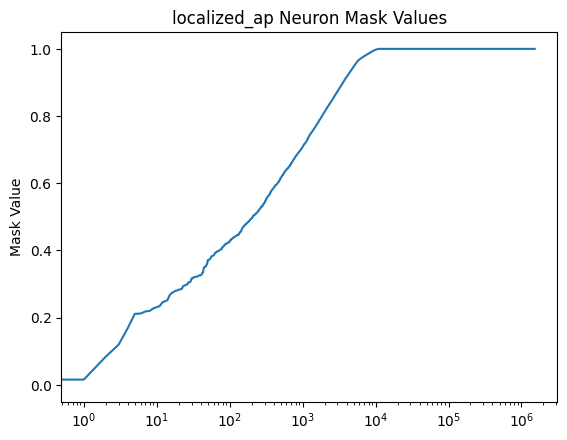

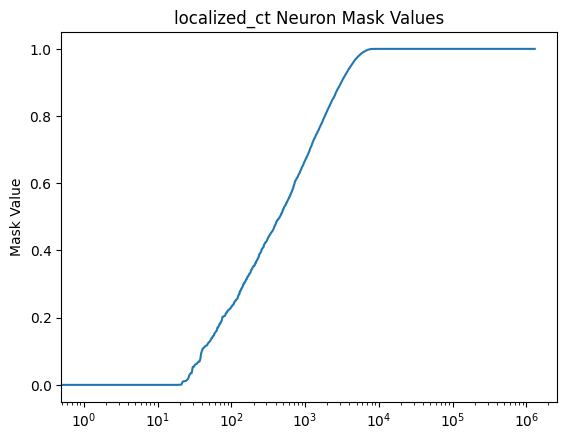

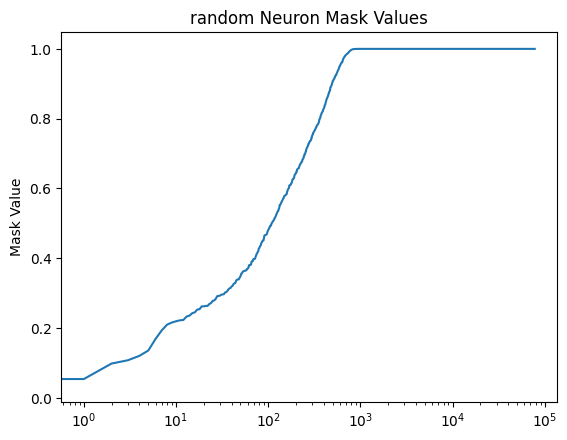

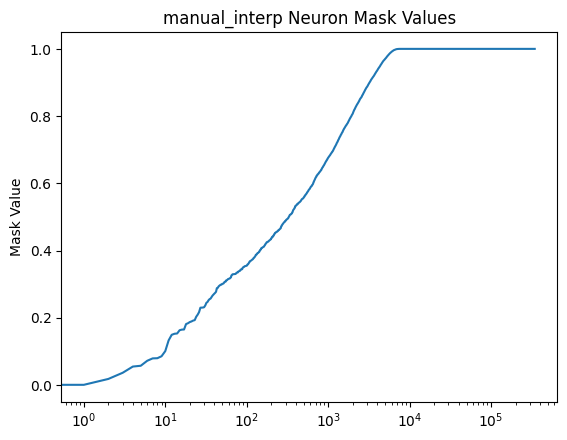

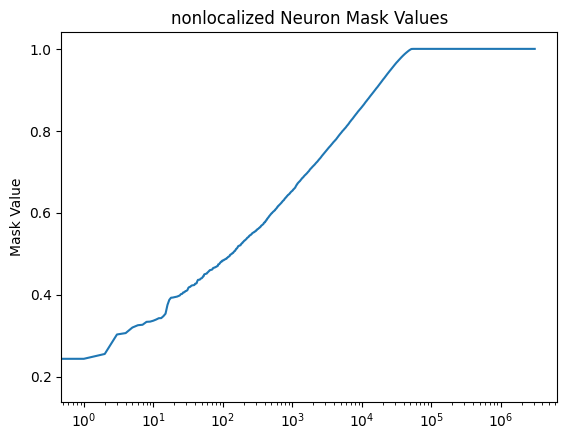

In [7]:
# Visualize the neuron coefficients
# for title, mask in [("Localized", localized_mask), ("Non-Localized", nonlocalized_mask)]:
# for title, mask in masks.items():
for title in mask_init_and_load_funcs:
    mask = mask_init_and_load_funcs[title](model)
    mask.cuda()
    all_values = torch.cat([m.data.flatten() for m in mask.masks.values()], dim=0).cpu()
    sorted_values = all_values.sort().values
    plt.semilogx(sorted_values)
    plt.title(f"{title} Neuron Mask Values")
    plt.ylabel("Mask Value")
    plt.show()

    mask.cpu()
    model.reset_hooks()
    del mask
# all_values = torch.cat([m.data.flatten() for m in mask.masks.values()], dim=0).cpu()
# sorted = all_values.sort().values
# plt.semilogx(sorted)
# plt.title("Neuron Mask Values")
# plt.ylabel("Mask Value")
# plt.show()


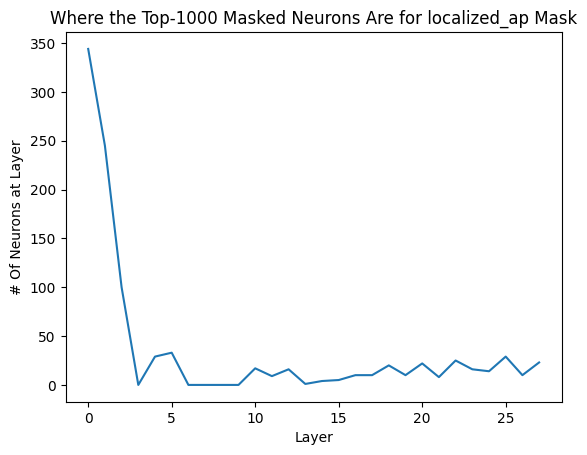

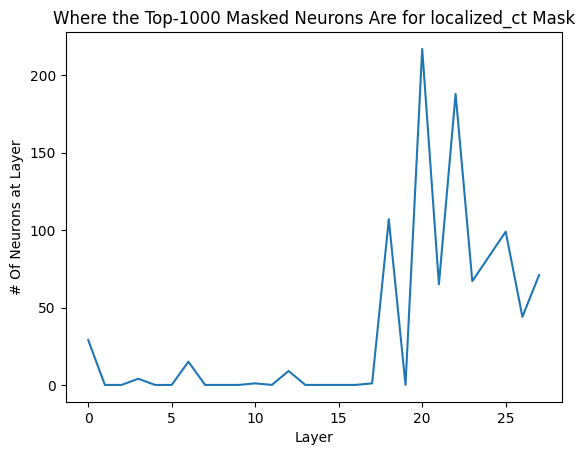

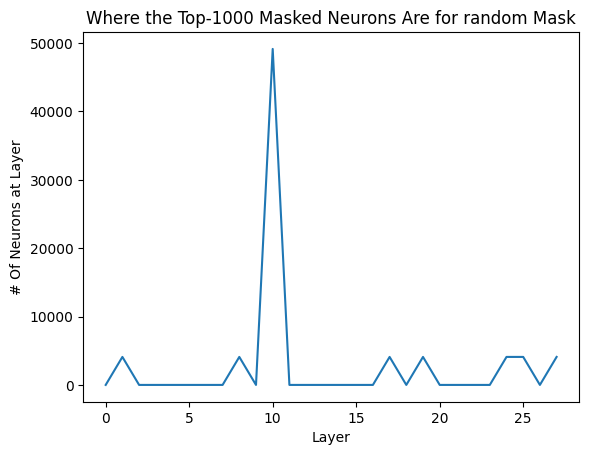

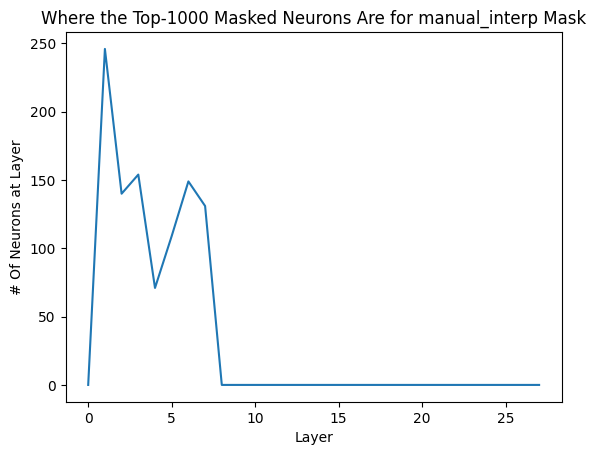

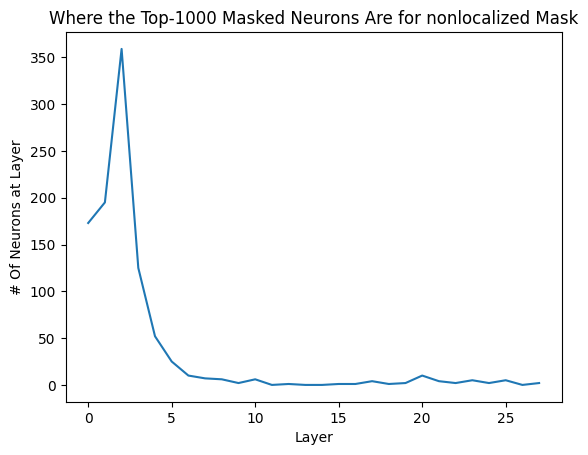

In [8]:
# Visualize the neuron coefficients
top_k = 1000
# for title, mask in [("Localized", localized_mask), ("Non-Localized", nonlocalized_mask)]:
# for title, mask in masks.items():
for title in mask_init_and_load_funcs:
    mask = mask_init_and_load_funcs[title](model)
    mask.undiscretize()
    mask.discretize_topk(top_k)
    all_values = {layer: 0 for layer in range(model.cfg.n_layers)}
    for component in mask.mask_masks:
        layer = int(component.split("&")[1])
        all_values[layer] += (mask.mask_masks[component].data == 1).sum().item()

    # all_values = [(m.data == 1).sum().item() for m in mask.mask_masks.values()]
    plt.plot(all_values.values())
    plt.title(f"Where the Top-{top_k} Masked Neurons Are for {title} Mask")
    plt.ylabel("# Of Neurons at Layer")
    plt.xlabel("Layer")
    plt.show()

    mask.cpu()
    model.reset_hooks()
    del mask


In [ ]:
# plot sum of mask values of layer

for title in mask_init_and_load_funcs:
    mask = mask_init_and_load_funcs[title](model)
    layer_sums = defaultdict(int)
    for component in mask.mask_masks:
        layer = int(component.split("&")[1])
        layer_sums[layer] += (1-mask.masks[component].data).sum().item()

    # all_values = [(m.data == 1).sum().item() for m in mask.mask_masks.values()]
    plt.plot(all_values.values())
    plt.title(f"Where the Top-{top_k} Masked Neurons Are for {title} Mask")
    plt.ylabel("# Of Neurons at Layer")
    plt.xlabel("Layer")
    plt.show()

    mask.cpu()
    model.reset_hooks()
    del mask


In [9]:
torch.cuda.empty_cache()
torch.cuda.memory_allocated() // 1024 // 1024 // 1024


19

In [10]:
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval_redo


model.reset_hooks()
for title in mask_init_and_load_funcs:
    print(f"Final evals for {title} Mask")
    # model = models[title]
    mask = mask_init_and_load_funcs[title](model)
    print(f"Loaded mask {title} into model")
    # model.cuda()
    mask.cuda()
    mask.undiscretize()

    # final_adversarial_eval = adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=True, continuous=True)
    # print(f"System Prompt: adversarial evals are {final_adversarial_eval}")
    # final_adversarial_eval = adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=False, continuous=True)
    # print(f"No System Prompt: adversarial evals are {final_adversarial_eval}")
    final_adversarial_eval = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, 
                                                          forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|forget_kwargs, 
                                                          maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|maintain_kwargs, 
                                                          continuous=True)
    print(f"System Prompt: adversarial evals are {final_adversarial_eval}")
    final_adversarial_eval = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, 
                                                        forget_task_init_kwargs={"use_system_prompt":False, "use_icl":False}|forget_kwargs, 
                                                        maintain_task_init_kwargs={"use_system_prompt":False, "use_icl":False}|maintain_kwargs, 
                                                        continuous=True)
    print(f"No System Prompt: adversarial evals are {final_adversarial_eval}")

    final_side_effects = run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["Sports Answers", "MMLU", "Cross Entropy"], verbose=False)
    print(final_side_effects)

    mask.cpu()
    model.reset_hooks()
    del mask

Final evals for localized_ap Mask
Loaded mask localized_ap into model


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


System Prompt: adversarial evals are {'Normal': {'forget': 0.392578125, 'maintain': 0.98828125}, 'MC': {'forget': 0.447265625, 'maintain': 0.94296875}, 'Capitalized': {'forget': 0.40625, 'maintain': 0.9875}, 'Dashed': {'forget': 0.40255057215690615, 'maintain': 0.7990035653114318}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No System Prompt: adversarial evals are {'Normal': {'forget': 0.31640625, 'maintain': 0.9875}, 'MC': {'forget': 0.384765625, 'maintain': 0.8570312499999999}, 'Capitalized': {'forget': 0.314453125, 'maintain': 0.9875}, 'Dashed': {'forget': 0.3765316784381866, 'maintain': 0.912466037273407}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

{'Sports Answers': {'football': 0.98, 'baseball': 1.0, 'basketball': 1.0, 'tennis': 0.9}, 'Cross Entropy': {'Pile': 2.3125, 'OWT': 2.540625}}
Final evals for localized_ct Mask
Loaded mask localized_ct into model
System Prompt: adversarial evals are {'Normal': {'forget': 0.9921875, 'maintain': 0.9906250000000001}, 'MC': {'forget': 0.9453125, 'maintain': 0.9242187500000001}, 'Capitalized': {'forget': 0.984375, 'maintain': 0.99375}, 'Dashed': {'forget': 0.8565510511398315, 'maintain': 0.8793356537818908}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No System Prompt: adversarial evals are {'Normal': {'forget': 0.98828125, 'maintain': 0.9859375}, 'MC': {'forget': 0.86328125, 'maintain': 0.85703125}, 'Capitalized': {'forget': 0.98828125, 'maintain': 0.9859374999999999}, 'Dashed': {'forget': 0.9307409286499024, 'maintain': 0.9308449268341065}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

{'Sports Answers': {'football': 1.0, 'baseball': 1.0, 'basketball': 1.0, 'tennis': 0.98}, 'Cross Entropy': {'Pile': 2.328125, 'OWT': 2.540625}}
Final evals for random Mask
Loaded mask random into model
System Prompt: adversarial evals are {'Normal': {'forget': 0.9921875, 'maintain': 0.99140625}, 'MC': {'forget': 0.9375, 'maintain': 0.9312500000000001}, 'Capitalized': {'forget': 0.98828125, 'maintain': 0.984375}, 'Dashed': {'forget': 0.8088793635368348, 'maintain': 0.8195043087005616}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No System Prompt: adversarial evals are {'Normal': {'forget': 0.9921875, 'maintain': 0.98203125}, 'MC': {'forget': 0.8203125, 'maintain': 0.82109375}, 'Capitalized': {'forget': 0.9921875, 'maintain': 0.9812500000000001}, 'Dashed': {'forget': 0.9314954042434692, 'maintain': 0.9283052802085876}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

{'Sports Answers': {'football': 1.0, 'baseball': 1.0, 'basketball': 1.0, 'tennis': 1.0}, 'Cross Entropy': {'Pile': 2.340625, 'OWT': 2.515625}}
Final evals for manual_interp Mask
Loaded mask manual_interp into model
System Prompt: adversarial evals are {'Normal': {'forget': 0.515625, 'maintain': 0.98828125}, 'MC': {'forget': 0.494140625, 'maintain': 0.92421875}, 'Capitalized': {'forget': 0.53125, 'maintain': 0.98359375}, 'Dashed': {'forget': 0.4547210931777954, 'maintain': 0.8255661606788636}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No System Prompt: adversarial evals are {'Normal': {'forget': 0.4375, 'maintain': 0.9984374999999999}, 'MC': {'forget': 0.39453125, 'maintain': 0.7843749999999999}, 'Capitalized': {'forget': 0.421875, 'maintain': 0.9937499999999999}, 'Dashed': {'forget': 0.38689064383506777, 'maintain': 0.9260223746299744}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

{'Sports Answers': {'football': 0.98, 'baseball': 1.0, 'basketball': 1.0, 'tennis': 0.88}, 'Cross Entropy': {'Pile': 2.315625, 'OWT': 2.525}}
Final evals for nonlocalized Mask
Loaded mask nonlocalized into model
System Prompt: adversarial evals are {'Normal': {'forget': 0.0159912109375, 'maintain': 0.98515625}, 'MC': {'forget': 0.0830078125, 'maintain': 0.91171875}, 'Capitalized': {'forget': 0.0108642578125, 'maintain': 0.9757812499999998}, 'Dashed': {'forget': 0.09787462651729584, 'maintain': 0.7689529776573181}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No System Prompt: adversarial evals are {'Normal': {'forget': 0.006622314453125, 'maintain': 0.9859374999999999}, 'MC': {'forget': 0.064453125, 'maintain': 0.9328125}, 'Capitalized': {'forget': 0.008544921875, 'maintain': 0.9781249999999999}, 'Dashed': {'forget': 0.0683750256896019, 'maintain': 0.8948548197746278}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

{'Sports Answers': {'football': 0.98, 'baseball': 1.0, 'basketball': 1.0, 'tennis': 0.92}, 'Cross Entropy': {'Pile': 2.309375, 'OWT': 2.540625}}


### Pareto Plots

In [11]:
# mask_k_vals = [1, 2, 5, 10, 20, 40, 80, 160, 320, 640]
mask_k_vals = [10, 20, 40, 80, 160, 240, 320, 480, 640, 960]
# mask_k_vals = [25, 50, 100, 150, 200, 300, 400, 600, 800, 1200, 1600, 2400, 3200]
# mask_k_vals = [5, 160]


all_regular_evals = {}
all_side_effect_evals = {}
all_adversarial_evals = {}

# with open(f"results/neuron_cb_{beta=}_pareto_comparisons.pkl", "rb") as f:
#     all_regular_evals = previous_evals['all_regular_evals']
#     all_side_effect_evals = previous_evals['all_side_effect_evals']
#     all_adversarial_evals = previous_evals['all_adversarial_evals']

all_regular_evals

{}

In [24]:
n_eval_iters = 15
all_side_effect_evals = {}

# for name, model, mask, regular_evals, side_effect_evals, adversarial_evals in [("localized", localized_model, localized_mask, localized_regular_evals, localized_side_effect_evals, localized_adversarial_evals), ("nonlocalized", nonlocalized_model, nonlocalized_mask, nonlocalized_regular_evals, nonlocalized_side_effect_evals, nonlocalized_adversarial_evals)]:
for name in mask_init_and_load_funcs:
    mask = mask_init_and_load_funcs[name](model)
    mask.cuda()

    # regular_evals = {}
    side_effect_evals = {}
    # adversarial_evals = {}
    for k in tqdm(mask_k_vals):
        mask.undiscretize()
        mask.discretize_topk(k)
        
        # first do the regular evals
        # regular_evals[k] = {}
        # for task_name, task in eval_tasks.items():
        #     task_loss = 0
        #     task_accuracy = 0
        #     for i in range(n_eval_iters):
        #         task_loss += task.get_test_loss(model).item()
        #         task_accuracy += task.get_test_accuracy(model)
        #     regular_evals[k][f"{task_name}_ce"] = task_loss / n_eval_iters
        #     regular_evals[k][f"{task_name}_acc"] = task_accuracy / n_eval_iters


        # adversarial_evals[k] = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, 
        #     forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|forget_kwargs, 
        #     maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|maintain_kwargs, 
        #     continuous=True)

        side_effect_evals[k] = run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["General"], verbose=False)

        # then do the side effect evals
        # side_effect_evals[k] = run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["Sports Answers", "Cross Entropy"], verbose=False, n_iters=n_eval_iters) # output is dictionary of dictionaries, first keys are eval_types ("Sports Answers", "Cross Entropy"), and nested keys are either different sports or different cross entropy measures, and nested values are eval values

        # then do the adversarial evals
        # adversarial_evals[k] = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=True, continuous=True, n_iters=n_eval_iters) # output is a dictionary of dictionaries, first keys are eval_types ("Normal", "MC", "Capitalized", "Dashed"), and nested keys are different sports ("baseball", "football", "basketball"), and nested values are accuracies
        # adversarial_evals[k] = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, task_init_kwargs={"use_system_prompt":True, "use_icl":False, "forget_sport_subset":{"basketball"}}, continuous=True, n_iters=n_eval_iters)

    # all_regular_evals[name] = regular_evals
    all_side_effect_evals[name] = side_effect_evals
    # all_adversarial_evals[name] = adversarial_evals

    mask.cpu()
    model.reset_hooks()
    del mask


  0%|          | 0/10 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default 

  0%|          | 0/10 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to tru

  0%|          | 0/10 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to tru

  0%|          | 0/10 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to tru

  0%|          | 0/10 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to tru

In [26]:
# save all results
# with open(f"results/neuron_cb_{beta=}_pareto_comparisons.pkl", "wb") as f:
with open(f"{save_dir}/results/neuron_cb_unlearn_athletes_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}_pareto_comparisons.pkl", "wb") as f:
    # pickle.dump({"localized_regular_evals": localized_regular_evals, "localized_side_effect_evals": localized_side_effect_evals, "localized_adversarial_evals": localized_adversarial_evals, "nonlocalized_regular_evals": nonlocalized_regular_evals, "nonlocalized_side_effect_evals": nonlocalized_side_effect_evals, "nonlocalized_adversarial_evals": nonlocalized_adversarial_evals}, f)
    pickle.dump({"all_regular_evals": all_regular_evals, "all_side_effect_evals": all_side_effect_evals, "all_adversarial_evals": all_adversarial_evals}, f)


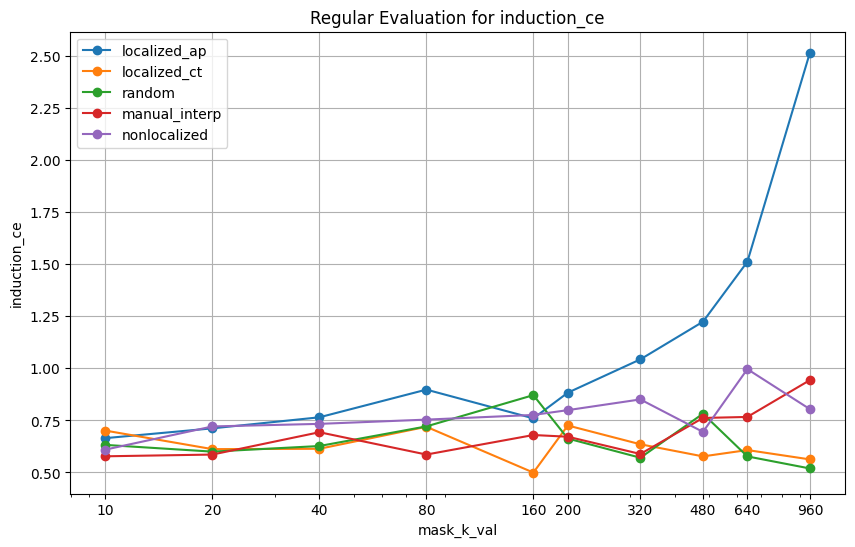

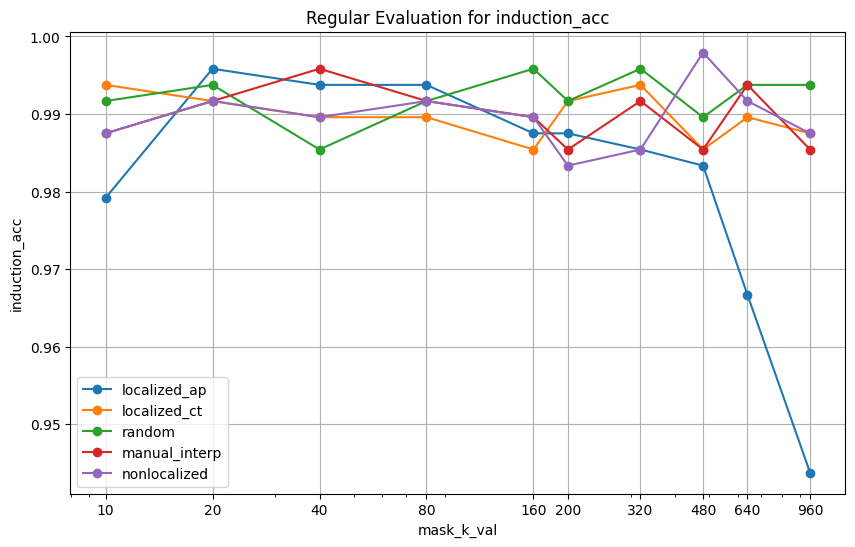

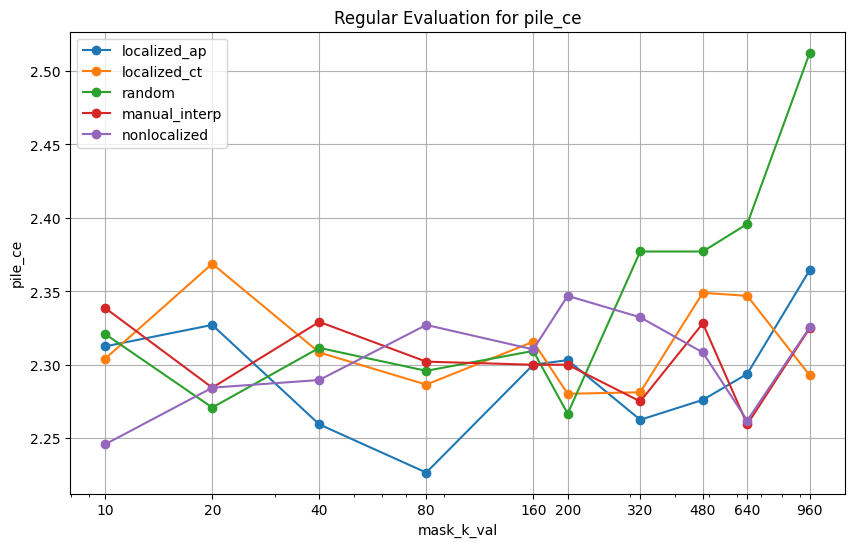

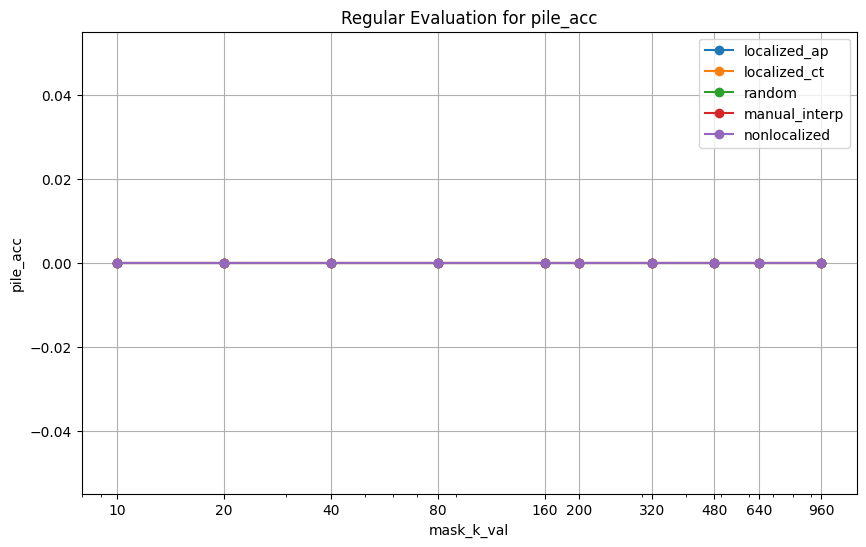

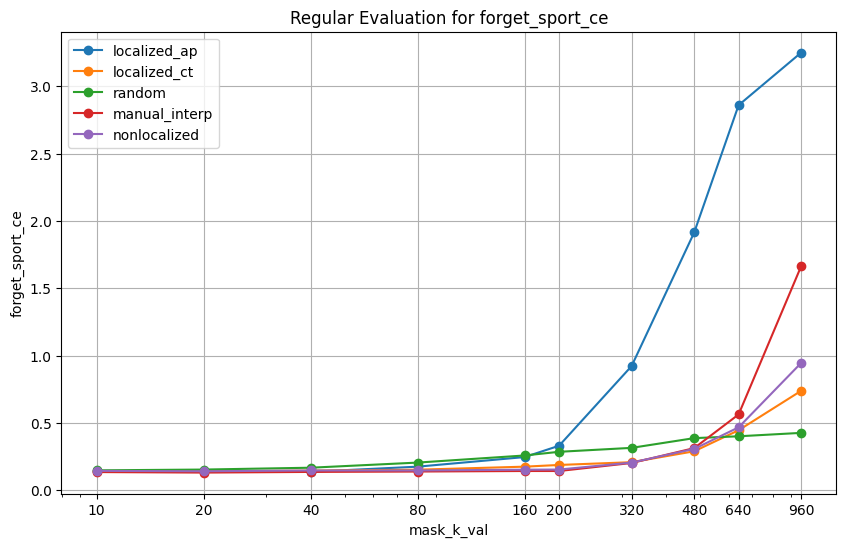

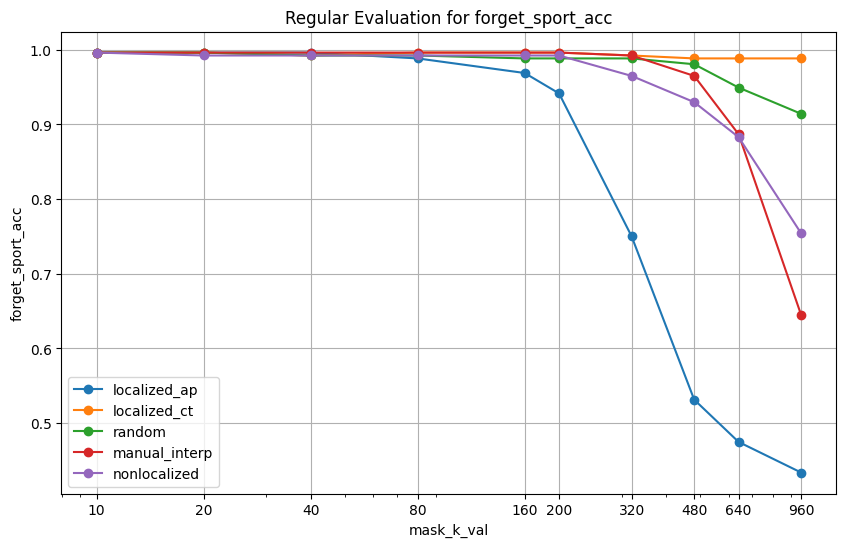

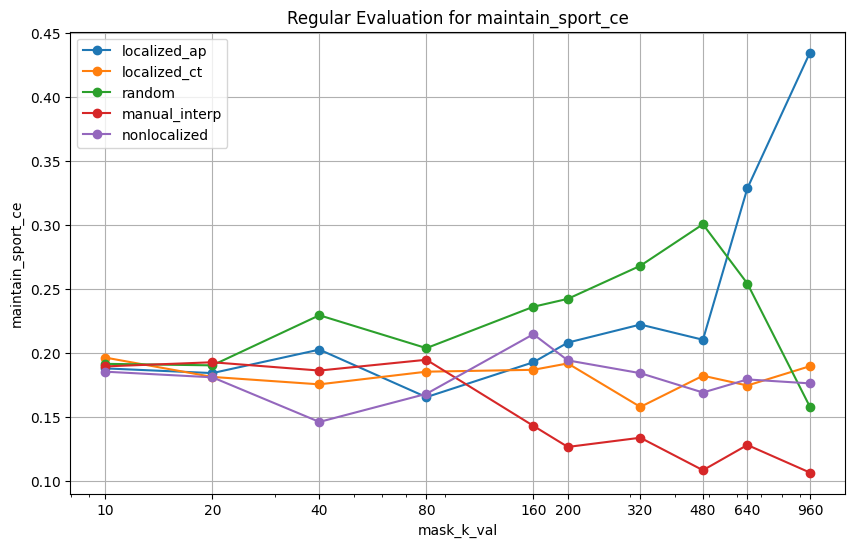

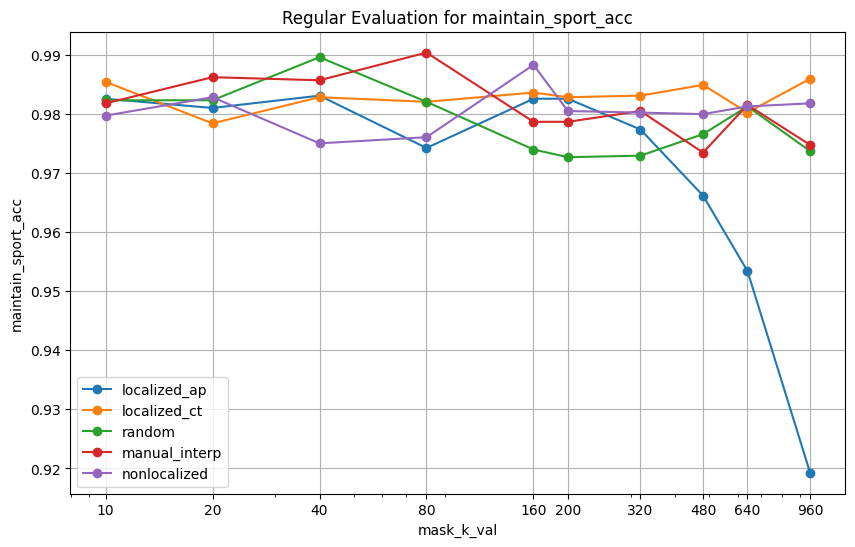

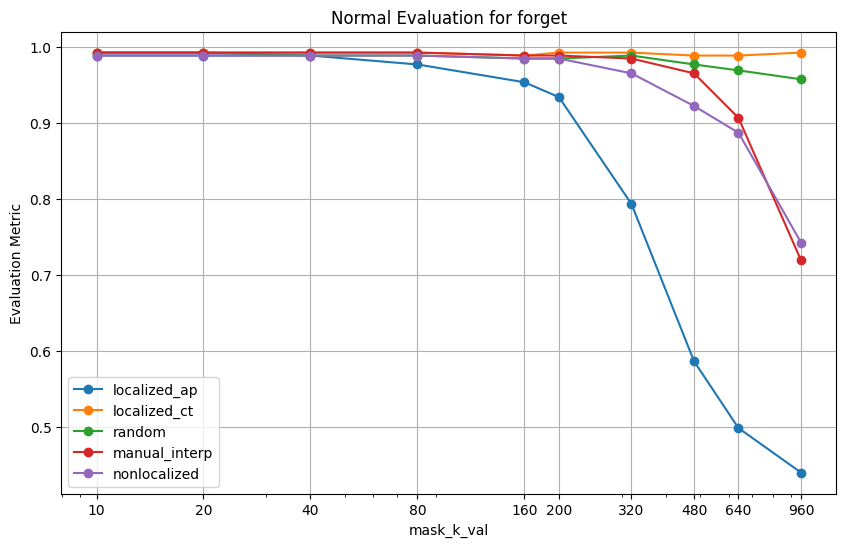

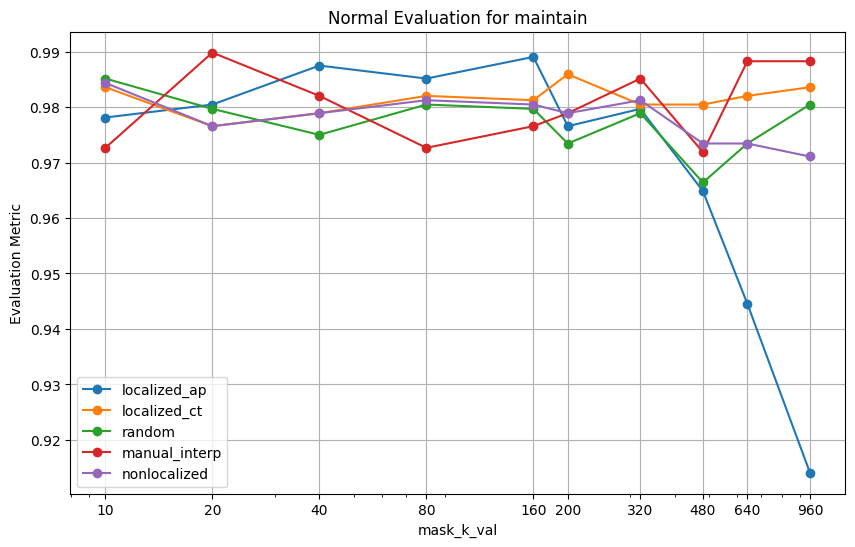

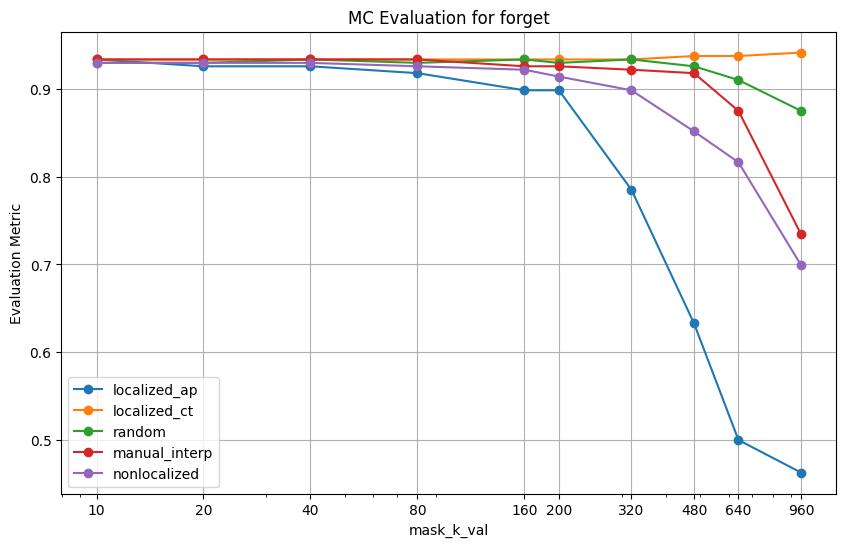

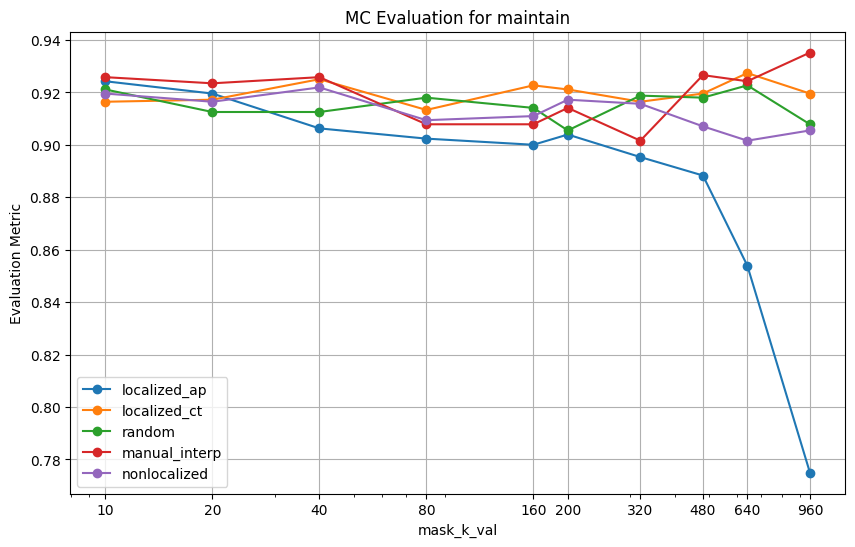

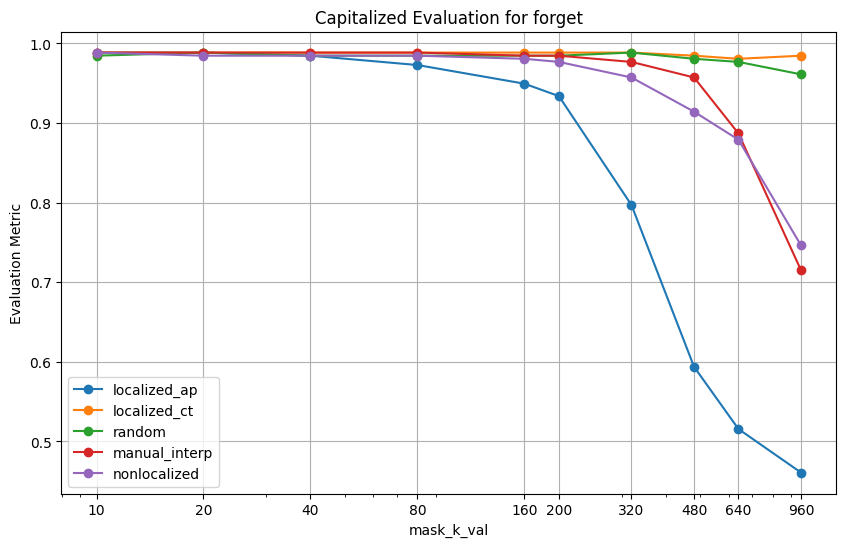

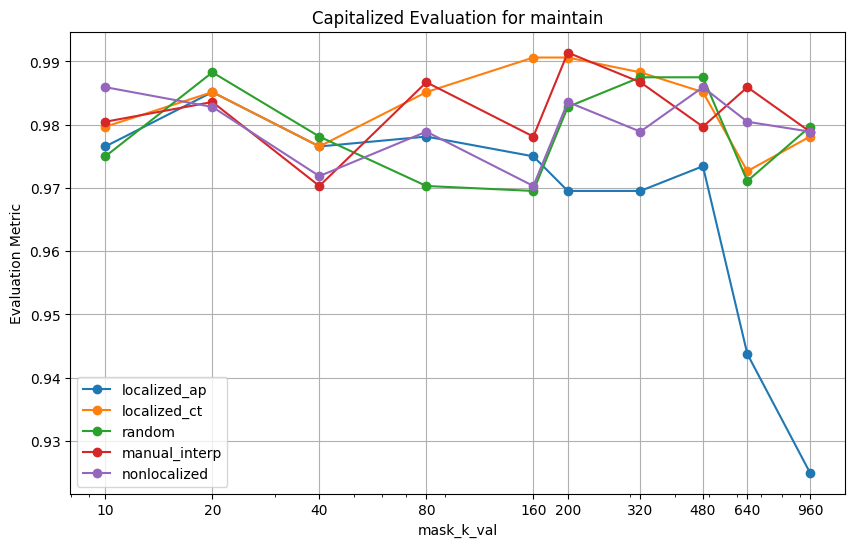

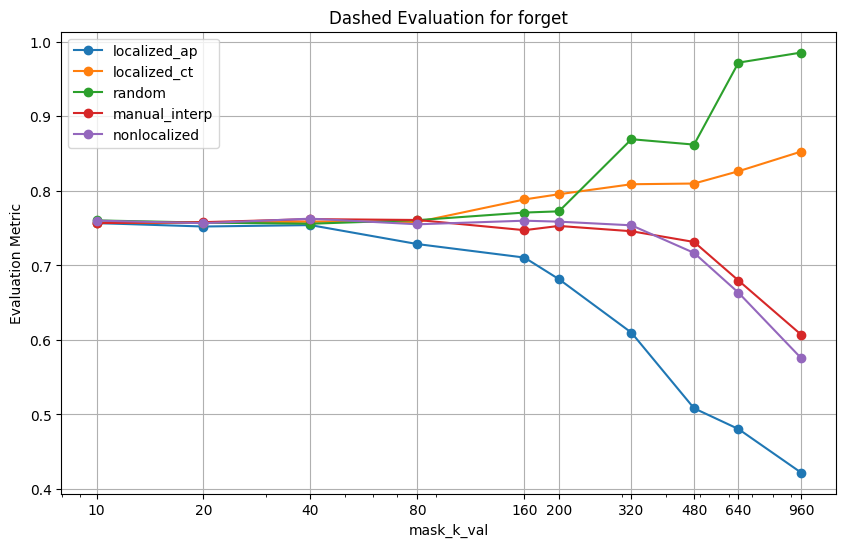

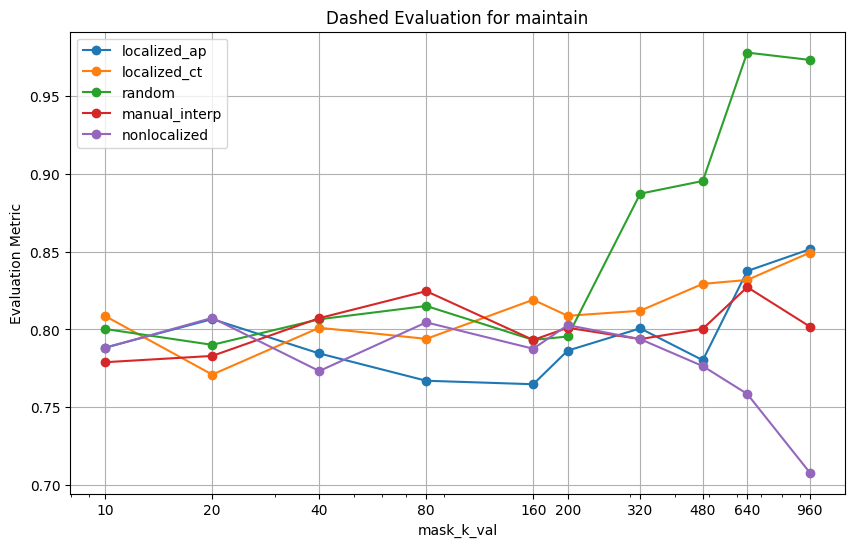

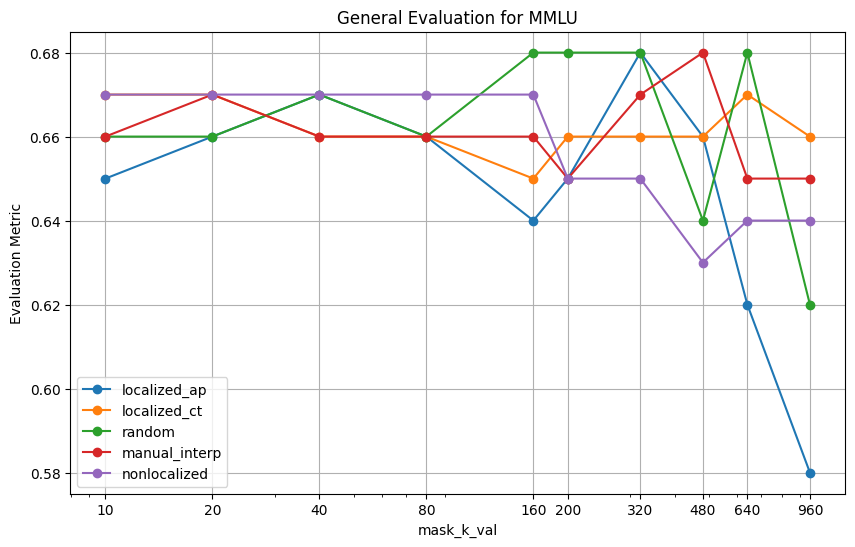

In [28]:
import pickle
beta=3
with open(f"{save_dir}/results/neuron_cb_unlearn_athletes_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}_pareto_comparisons.pkl", "rb") as f:
    results = pickle.load(f)
    all_regular_evals = results['all_regular_evals']
    all_side_effect_evals = results['all_side_effect_evals']
    all_adversarial_evals = results['all_adversarial_evals']
    # localized_regular_evals = results['localized_regular_evals']
    # localized_side_effect_evals = results['localized_side_effect_evals']
    # localized_adversarial_evals = results['localized_adversarial_evals']
    # nonlocalized_regular_evals = results['nonlocalized_regular_evals']
    # nonlocalized_side_effect_evals = results['nonlocalized_side_effect_evals']
    # nonlocalized_adversarial_evals = results['nonlocalized_adversarial_evals']

import matplotlib.pyplot as plt
import numpy as np

def plot_regular_evaluations(task_regular_evals, task_name, y_label="Evaluation Metric", mask_k_vals=None):
    plt.figure(figsize=(10, 6))

    sample_key = list(task_regular_evals.keys())[0]
    if mask_k_vals is None:
        mask_k_vals = sorted(task_regular_evals[sample_key].keys())

    for localization_type, regular_evals in task_regular_evals.items():
        if mask_k_vals is None:
            mask_k_vals = sorted(regular_evals.keys())
        # mask_k_vals = sorted(regular_evals.keys())
        scores = [regular_evals[k][task_name] for k in mask_k_vals]
        plt.plot(mask_k_vals, scores, label=localization_type, marker='o')

    # mask_k_vals = sorted(all_regular_evals['localized'].keys())

    # mask_k_vals = sorted(localized_evals.keys())
    # localized_scores = [localized_evals[k][task_name] for k in mask_k_vals]
    # nonlocalized_scores = [nonlocalized_evals[k][task_name] for k in mask_k_vals]

    # plt.plot(mask_k_vals, localized_scores, label='Localized', marker='o')
    # plt.plot(mask_k_vals, nonlocalized_scores, label='Nonlocalized', marker='o')
    plt.xlabel('mask_k_val')
    plt.ylabel(y_label)
    plt.title(f'Regular Evaluation for {task_name}')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xticks(mask_k_vals, labels=mask_k_vals)  # Ensure ticks are set correctly for log scale
    plt.show()

# def plot_nested_evaluations_with_checks(localized_evals, nonlocalized_evals, eval_type, nested_key):
#     mask_k_vals = sorted(localized_evals.keys())
#     localized_scores = []
#     nonlocalized_scores = []

#     for k in mask_k_vals:
#         # Check and append localized scores
#         if eval_type in localized_evals[k] and nested_key in localized_evals[k][eval_type]:
#             localized_scores.append(localized_evals[k][eval_type][nested_key])
#         else:
#             localized_scores.append(None)  # or use -1 or np.nan

#         # Check and append nonlocalized scores
#         if eval_type in nonlocalized_evals[k] and nested_key in nonlocalized_evals[k][eval_type]:
#             nonlocalized_scores.append(nonlocalized_evals[k][eval_type][nested_key])
#         else:
#             nonlocalized_scores.append(None)  # or use -1 or np.nan

#     plt.figure(figsize=(10, 6))
#     plt.plot(mask_k_vals, localized_scores, label='Localized', marker='o')
#     plt.plot(mask_k_vals, nonlocalized_scores, label='Nonlocalized', marker='o')
#     plt.xlabel('mask_k_val')
#     plt.ylabel('Evaluation Metric')
#     plt.title(f'{eval_type} Evaluation for {nested_key}')
#     plt.legend()
#     plt.grid(True)
#     plt.xscale('log')  # Set x-axis to logarithmic scale
#     plt.xticks(mask_k_vals, labels=mask_k_vals)  # Ensure ticks are set correctly for log scale
#     plt.show()
def plot_nested_evaluations_with_checks(all_evals, eval_type, nested_key, mask_k_vals=None):
    plt.figure(figsize=(10, 6))
    if mask_k_vals is None:
        mask_k_vals = sorted(next(iter(all_evals.values())).keys())  # Assuming all have the same k values

    for localization_type, evals in all_evals.items():
        scores = []
        for k in mask_k_vals:
            if eval_type in evals[k] and nested_key in evals[k][eval_type]:
                scores.append(evals[k][eval_type][nested_key])
            else:
                scores.append(None)  # or use -1 or np.nan
        plt.plot(mask_k_vals, scores, label=localization_type, marker='o')

    plt.xlabel('mask_k_val')
    plt.ylabel('Evaluation Metric')
    plt.title(f'{eval_type} Evaluation for {nested_key}')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xticks(mask_k_vals, labels=mask_k_vals)  # Ensure ticks are set correctly for log scale
    plt.show()

# Plotting regular evaluations
# for task in ['induction', 'pile', 'forget_sport', 'maintain_sport']:

# for task in list(localized_regular_evals.values())[0].keys():
#     plot_regular_evaluations(localized_regular_evals, nonlocalized_regular_evals, task, y_label=task)
mask_k_vals = [10, 20, 40, 80, 160, 200, 320, 480, 640, 960]
sample_key = list(all_regular_evals.keys())[0]
for task in list(all_regular_evals[sample_key].values())[0].keys():
    plot_regular_evaluations(all_regular_evals, task, y_label=task, mask_k_vals=mask_k_vals)


# Plotting adversarial evaluations
for eval_type in ['Normal', 'MC', 'Capitalized', 'Dashed']:
    for sport in ['forget', 'maintain']:
        plot_nested_evaluations_with_checks(all_adversarial_evals, eval_type, sport, mask_k_vals=mask_k_vals)

# Plotting side effect evaluations with checks for missing keys
# for eval_type in ['Sports Answers', 'Cross Entropy', 'General']:
for eval_type in ['General']:
    if eval_type == 'Sports Answers':
        for sport in ['football', 'baseball', 'basketball', 'tennis']:
            plot_nested_evaluations_with_checks(all_side_effect_evals, eval_type, sport, mask_k_vals=mask_k_vals)
    elif eval_type == 'Cross Entropy':
        for category in ['Pile', 'OWT']:
            plot_nested_evaluations_with_checks(all_side_effect_evals, eval_type, category, mask_k_vals=mask_k_vals)
    elif eval_type == 'General':
        for metric in ['MMLU']:
            plot_nested_evaluations_with_checks(all_side_effect_evals, eval_type, metric, mask_k_vals=mask_k_vals)

# # Plotting adversarial evaluations
# # for eval_type in ['Normal', 'MC', 'Capitalized', 'Dashed']:
# for eval_type in list(localized_adversarial_evals.values())[0].keys():
#     # for sport in ['football', 'baseball', 'basketball']:
#     for sport in list(localized_adversarial_evals.values())[0][eval_type].keys():
#         plot_nested_evaluations_with_checks(localized_adversarial_evals, nonlocalized_adversarial_evals, eval_type, sport)

# # Plotting side effect evaluations with checks for missing keys
# for eval_type in ['Sports Answers', 'Cross Entropy']:
#     if eval_type == 'Sports Answers':
#         for sport in ['football', 'baseball', 'basketball', 'tennis']:
#             plot_nested_evaluations_with_checks(localized_side_effect_evals, nonlocalized_side_effect_evals, eval_type, sport)
#     elif eval_type == 'Cross Entropy':
#         for category in ['Pile', 'OWT']:
#             plot_nested_evaluations_with_checks(localized_side_effect_evals, nonlocalized_side_effect_evals, eval_type, category)


### Scatterplots

In [ ]:
# scatterplot of neuron mask values, x_axis and y_axis are different localizations

def plot_

## Relearning Evals

In [5]:
from peft import get_peft_model, LoraConfig, TaskType
def do_relearning(model, train_tasks, n_iters, finetune_lora=False, lora_kwargs={'rank': 64, 'alpha': 32, 'dropout': 0.05, 'target_modules': 'all-linear'}, learning_kwargs={'lr': 1e-2, 'weight_decay': 0, 'use_cosine': False}, eval_callback_fn=None):
    # can either finetune full or lora

    if not finetune_lora:
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_kwargs['lr'], weight_decay=learning_kwargs['weight_decay'])

    elif finetune_lora:
        peft_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            inference_mode=False,
            r=lora_kwargs['rank'],
            lora_alpha=lora_kwargs['alpha'],
            lora_dropout=lora_kwargs['dropout'],
            target_modules = lora_kwargs['target_modules'], #["q_proj", "v_proj", 
        )

        model = get_peft_model(model, peft_config).cuda()
        # model.print_trainable_parameters()

        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_kwargs['lr'], weight_decay=learning_kwargs['weight_decay'])
    
    if learning_kwargs['use_cosine']:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_iters)

    train_losses = defaultdict(list)
    test_losses = []

    for i in tqdm(range(n_iters)):
        optimizer.zero_grad()
        for task_name, (task, task_weight) in train_tasks.items():
            loss = task.get_train_loss(model)
            train_losses[task_name].append(loss.item())
            # print(loss.item())
            (loss * task_weight).backward()
        
        optimizer.step()
        if learning_kwargs['use_cosine']:
            scheduler.step()

        if eval_callback_fn is not None:
            test_losses.append(eval_callback_fn(model))

    if len(test_losses) > 0:
        return train_losses, test_losses
    return train_losses

In [18]:
combine_heads = False
model_paths_dict = {
    localization_type: f"{save_dir}/models/{model_type}_{localization_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt" for localization_type in localization_types
}
def model_init_and_load_func(mask_type):
    model_path = model_paths_dict[mask_type]
    def get_model_fn():
        model = AutoModelForCausalLM.from_pretrained("google/gemma-7b", torch_dtype=torch.bfloat16)
        model.load_state_dict(torch.load(model_path))
        return model
    return get_model_fn
model_init_and_load_funcs = {mask_type: model_init_and_load_func(mask_type) for mask_type in localization_types}

In [7]:
n_eval_iters = 10
n_relearn_iters = 10
n_relearn_athletes = 2


if forget_sport is None:
    relearn_sport = SportsTask(batch_size=n_relearn_athletes, tokenizer=tokenizer, forget_player_subset=n_relearn_athletes, train_test_split=False, is_forget_dataset=True)
else:
    relearn_sport = SportsTask(batch_size=n_relearn_athletes, tokenizer=tokenizer, forget_sport_subset={forget_sport}, forget_player_subset=n_relearn_athletes, train_test_split=False, is_forget_dataset=True)

pile = PileTask(batch_size=8, tokenizer=tokenizer, ctx_length=256, shuffle=True, buffer_size=1000)
train_tasks = {"relearn_athletes": (relearn_sport, .2), "maintain_athletes": (maintain_sports, 1), "pile": (train_pile, 1)}

from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval_redo
from tasks.general_capabilities.MCTask_redo import run_general_evals

def eval_callback(model):
    mmlu_score = run_general_evals(model, model_type="gemma")["MMLU"]
    adversarial_results = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, 
                    forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|forget_kwargs, 
                    maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|maintain_kwargs, 
                    continuous=True, include_evals=["Normal", "MC"])

    # get dictionary of both
    return {"MMLU": mmlu_score, "adversarial": adversarial_results}

# del model

# for name, model, mask, regular_evals, side_effect_evals, adversarial_evals in [("localized", localized_model, localized_mask, localized_regular_evals, localized_side_effect_evals, localized_adversarial_evals), ("nonlocalized", nonlocalized_model, nonlocalized_mask, nonlocalized_regular_evals, nonlocalized_side_effect_evals, nonlocalized_adversarial_evals)]:

relearning_train_results = {}
relearning_test_results = {}
relearning_regular_results = {}
relearning_adversarial_results = {}
relearning_side_effect_results = {}

# for name in mask_init_funcs.keys():
for name in model_init_and_load_funcs.keys():
    print(f"Running relearning for {name}")

    model = model_init_and_load_funcs[name]()
    model.cuda()

    train_losses, test_losses = do_relearning(model, train_tasks, n_iters=n_relearn_iters, finetune_lora=True, learning_kwargs={'lr': 1e-4, 'weight_decay': 0, 'use_cosine': True}, eval_callback_fn=eval_callback)

    relearning_train_results[name] = train_losses
    relearning_test_results[name] = test_losses

    relearning_regular_results[name] = {}
    for task_name, test_task in [("forget_sport", forget_sport_eval), ("maintain_sports", maintain_sports_eval)]:
        task_loss = 0
        task_accuracy = 0
        for i in range(n_eval_iters):
            task_loss += test_task.get_test_loss(model).item()
            task_accuracy += test_task.get_test_accuracy(model)
        relearning_regular_results[name][f"{task_name}_ce"] = task_loss / n_eval_iters
        relearning_regular_results[name][f"{task_name}_acc"] = task_accuracy / n_eval_iters

    adversarial_eval_results = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, 
                    forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|forget_kwargs, 
                    maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|maintain_kwargs, 
                    continuous=True, include_evals=["Normal", "MC"])
    relearning_adversarial_results[name] = adversarial_eval_results

    side_effect_eval_results = run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["General"], general_batch_size=5)
    relearning_side_effect_results[name] = side_effect_eval_results

    model.cpu()
    del model


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.
Running relearning for localized_ap


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no pred

Running relearning for localized_ct


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no pred

Running relearning for random


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no pred

Running relearning for manual_interp


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no pred

Running relearning for nonlocalized


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no pred

In [12]:
relearning_test_results

{'localized_ap': [{'MMLU': 0.6300000000000001,
   'adversarial': {'Normal': {'forget': 0.01085205078125, 'maintain': 1.0},
    'MC': {'forget': 0.8976562499999999, 'maintain': 0.9367187499999999}}},
  {'MMLU': 0.65,
   'adversarial': {'Normal': {'forget': 0.39531249999999996, 'maintain': 1.0},
    'MC': {'forget': 0.8859375, 'maintain': 0.93125}}},
  {'MMLU': 0.5800000000000001,
   'adversarial': {'Normal': {'forget': 0.85546875, 'maintain': 1.0},
    'MC': {'forget': 0.88671875, 'maintain': 0.9382812500000001}}},
  {'MMLU': 0.6,
   'adversarial': {'Normal': {'forget': 0.9734375, 'maintain': 0.996875},
    'MC': {'forget': 0.8687499999999999, 'maintain': 0.9359374999999999}}},
  {'MMLU': 0.6100000000000001,
   'adversarial': {'Normal': {'forget': 0.9929687500000001,
     'maintain': 0.9906250000000001},
    'MC': {'forget': 0.87109375, 'maintain': 0.93359375}}},
  {'MMLU': 0.6100000000000001,
   'adversarial': {'Normal': {'forget': 0.96953125, 'maintain': 1.0},
    'MC': {'forget': 0.8

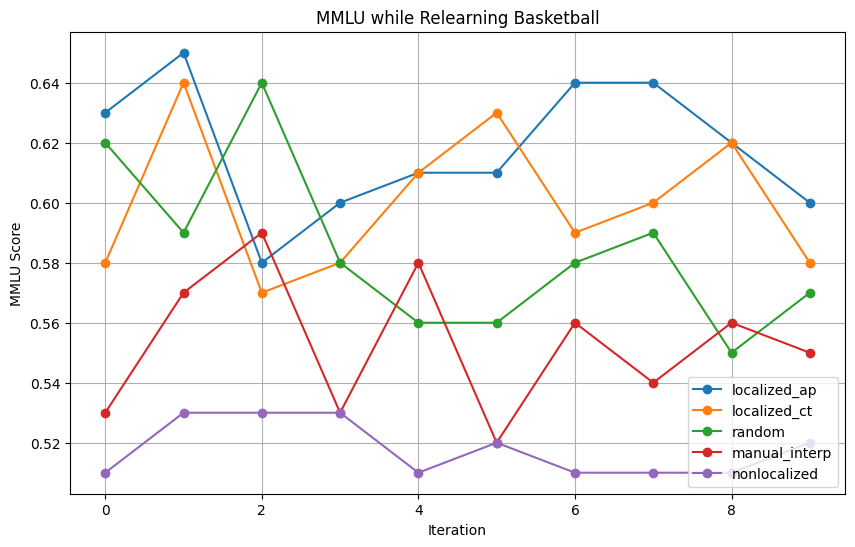

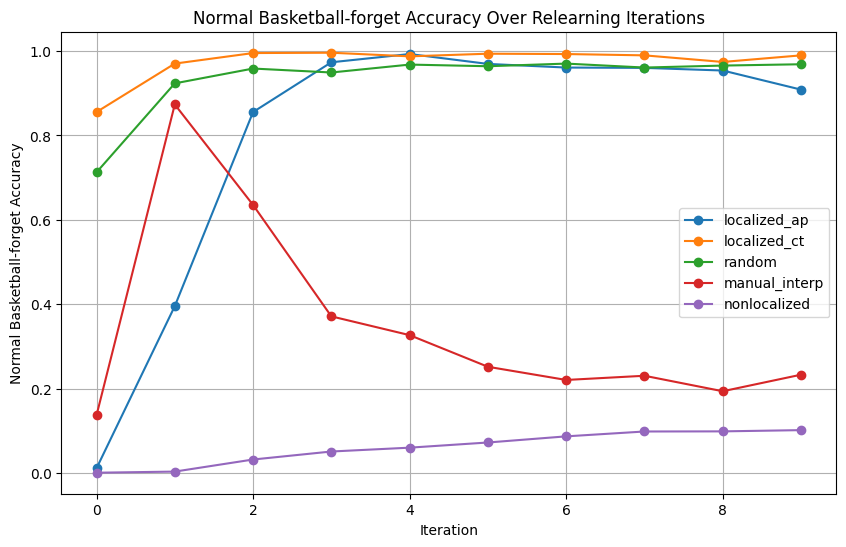

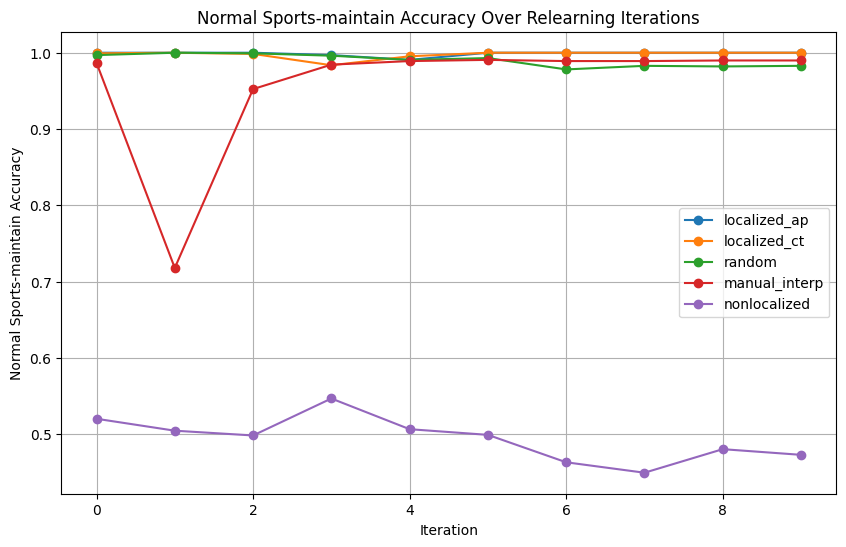

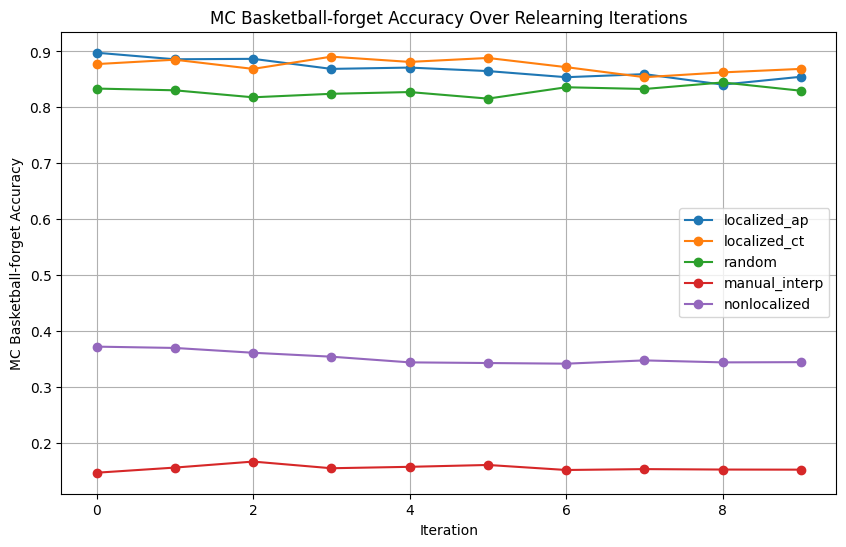

In [14]:
import matplotlib.pyplot as plt

# Function to plot relearning results
def plot_relearning_results(relearning_test_results, metric, title, ylabel):
    plt.figure(figsize=(10, 6))
    for name, results in relearning_test_results.items():
        values = [result[metric] if metric != 'adversarial' else result[metric]['Normal']['forget'] for result in results]
        plt.plot(range(len(values)), values, label=name, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot MMLU
plot_relearning_results(relearning_test_results, 'MMLU', 'MMLU while Relearning Basketball', 'MMLU Score')

# Plot adversarial-normal-forget
def plot_adversarial_results(relearning_test_results, adversarial_type, forget_or_maintain, title, ylabel):
    plt.figure(figsize=(10, 6))
    for name, results in relearning_test_results.items():
        values = [result['adversarial'][adversarial_type][forget_or_maintain] for result in results]
        plt.plot(range(len(values)), values, label=name, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot adversarial-normal-forget
plot_adversarial_results(relearning_test_results, 'Normal', 'forget', 'Normal Basketball-forget Accuracy Over Relearning Iterations', 'Normal Basketball-forget Accuracy')

# Plot adversarial-normal-maintain
plot_adversarial_results(relearning_test_results, 'Normal', 'maintain', 'Normal Sports-maintain Accuracy Over Relearning Iterations', 'Normal Sports-maintain Accuracy')

# Plot adversarial-mc-forget
plot_adversarial_results(relearning_test_results, 'MC', 'forget', 'MC Basketball-forget Accuracy Over Relearning Iterations', 'MC Basketball-forget Accuracy')



In [15]:
os.makedirs(f"{save_dir}/results", exist_ok=True)
with open(f"{save_dir}/results/relearning_{n_relearn_athletes=}_{n_relearn_iters=}_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}_results.pkl", "wb") as f:
    pickle.dump({"relearning_regular_results": relearning_regular_results, "relearning_adversarial_results": relearning_adversarial_results, "relearning_side_effect_results": relearning_side_effect_results, "relearning_train_results": relearning_train_results, "relearning_test_results": relearning_test_results}, f)

In [9]:
n_relearn_athletes = 2
n_relearn_iters = 10
model_type = "gemma"
combine_heads = False
beta = 3

with open(f"{save_dir}/results/relearning_{n_relearn_athletes=}_{n_relearn_iters=}_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}_results.pkl", "rb") as f:
    results = pickle.load(f)
    relearning_regular_results = results['relearning_regular_results']
    relearning_adversarial_results = results['relearning_adversarial_results']
    relearning_side_effect_results = results['relearning_side_effect_results']


In [10]:
relearning_regular_results

{'localized_ap': {'forget_sport_ce': 0.09588216145833334,
  'forget_sport_acc': 0.99609375,
  'maintain_sports_ce': 0.17384440104166668,
  'maintain_sports_acc': 0.9640625},
 'localized_ct': {'forget_sport_ce': 0.04928385416666667,
  'forget_sport_acc': 0.97421875,
  'maintain_sports_ce': 0.17789713541666666,
  'maintain_sports_acc': 0.95078125},
 'random': {'forget_sport_ce': 0.16399739583333334,
  'forget_sport_acc': 0.9364583333333333,
  'maintain_sports_ce': 0.14759724934895832,
  'maintain_sports_acc': 0.94609375},
 'manual_interp': {'forget_sport_ce': 4.427083333333333,
  'forget_sport_acc': 0.46171875,
  'maintain_sports_ce': 3.1510416666666665,
  'maintain_sports_acc': 0.33717447916666665},
 'nonlocalized': {'forget_sport_ce': 7.175,
  'forget_sport_acc': 0.4375,
  'maintain_sports_ce': 4.455208333333333,
  'maintain_sports_acc': 0.3350911458333333}}

In [12]:
relearning_adversarial_results

{'localized_ap': {'Normal': {'forget': 0.996875,
   'maintain': 0.9750000000000001},
  'MC': {'forget': 0.928125, 'maintain': 0.91796875}},
 'localized_ct': {'Normal': {'forget': 0.99609375, 'maintain': 0.95703125},
  'MC': {'forget': 0.96875, 'maintain': 0.94921875}},
 'random': {'Normal': {'forget': 0.9750000000000001,
   'maintain': 0.9554687499999999},
  'MC': {'forget': 0.93046875, 'maintain': 0.921875}},
 'manual_interp': {'Normal': {'forget': 0.5265625, 'maintain': 0.45625},
  'MC': {'forget': 0.39609375, 'maintain': 0.38085937500000006}},
 'nonlocalized': {'Normal': {'forget': 0.435546875, 'maintain': 0.3609375},
  'MC': {'forget': 0.35078125, 'maintain': 0.32695312499999996}}}

## Latent Knowledge

In [5]:
combine_heads = False
model_paths_dict = {
    localization_type: f"{save_dir}/models/{model_type}_{localization_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt" for localization_type in localization_types
}
def model_init_and_load_func(mask_type):
    model_path = model_paths_dict[mask_type]
    def get_model_fn():
        model = AutoModelForCausalLM.from_pretrained("google/gemma-7b", torch_dtype=torch.bfloat16)
        model.load_state_dict(torch.load(model_path))
        return model
    return get_model_fn
model_init_and_load_funcs = {mask_type: model_init_and_load_func(mask_type) for mask_type in localization_types}

In [6]:
left_tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
left_tokenizer.pad_token_id = left_tokenizer.eos_token_id
left_tokenizer.padding_side = "left"

from collections import defaultdict
def layer_hook_function(layer, outputs, last_token_only=True, store_cpu=False):
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            save_output = output[0].clone().detach()
        else:
            save_output = output.clone().detach()
        if last_token_only:
            save_output = save_output[:, -1]
        if store_cpu:
            save_output = save_output.cpu()
        outputs[layer].append(save_output)
        # return output
    return hook_fn

def get_hf_residuals(texts, model, batch_size, last_token_only=True, layers_module=None, store_cpu=True, text_col="prompt"):
    # needs left_
    outputs = defaultdict(list)
    hooks = []
    if layers_module is None:
        layers_module = model.model.layers
    for layer, block in enumerate(layers_module):
        hook_fn = layer_hook_function(layer, outputs=outputs, last_token_only=last_token_only, store_cpu=store_cpu)
        hook_applied = block.register_forward_hook(hook_fn)
        hooks.append(hook_applied)

    for idx in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[idx:idx+batch_size]
        tokenized = left_tokenizer(batch_texts, return_tensors="pt", padding=True)
        tokenized = {k: v.cuda() for k, v in tokenized.items()}
        with torch.no_grad():
            model(**tokenized)
    
    for layer in outputs:
        outputs[layer] = torch.cat(outputs[layer], dim=0)
        if store_cpu:
            outputs[layer] = outputs[layer].cpu()

    for hook in hooks:
        hook.remove()
    
    return outputs

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [18]:
batch_size = 16
def get_resids(sports_task, model):
    train_outputs = get_hf_residuals(sports_task.train_df["prompt"].tolist(), model, batch_size, last_token_only=True) # needs to not be last token only because of layernorm
    test_outputs = get_hf_residuals(sports_task.test_df["prompt"].tolist(), model, batch_size, last_token_only=True)

    train_labels = sports_task.train_df['sport'].tolist()
    test_labels = sports_task.test_df['sport'].tolist()
    return train_outputs, test_outputs, train_labels, test_labels

forget_is_split = True
if forget_is_split:
    forget_train_outputs_dict = {}
    forget_test_outputs_dict = {}
    forget_train_labels_dict = {}
    forget_test_labels_dict = {}
else:
    forget_outputs_dict = {}
    forget_labels_dict = {}

maintain_train_outputs_dict = {}
maintain_test_outputs_dict = {}
maintain_train_labels_dict = {}
maintain_test_labels_dict = {}

for model_name in model_init_and_load_funcs:
    model = model_init_and_load_funcs[model_name]()
    model.cuda()
    if forget_is_split:
        forget_train_outputs_dict[model_name], forget_test_outputs_dict[model_name], forget_train_labels_dict[model_name], forget_test_labels_dict[model_name] = get_resids(forget_sport_eval, model)
    else:
        forget_outputs_dict[model_name], _, forget_labels_dict[model_name], _ = get_resids(forget_sport, model)
    maintain_train_outputs_dict[model_name], maintain_test_outputs_dict[model_name], maintain_train_labels_dict[model_name], maintain_test_labels_dict[model_name] = get_resids(maintain_sports_eval, model)

    model.cpu()
    del model

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [19]:
# set train and test splits
if not forget_is_split:
    print("Performing manual split of the unsplit training dataset")
    train_test_split = .5
    forget_train_outputs_dict = {}
    forget_test_outputs_dict = {}
    forget_train_labels = {}
    forget_test_labels = {}
    for model_name in model_init_and_load_funcs:
        num_train = int(len(forget_labels_dict[model_name]) * train_test_split)
        forget_train_labels[model_name] = forget_labels_dict[model_name][:num_train]
        forget_test_labels[model_name] = forget_labels_dict[model_name][num_train:]
        for layer in range(n_layers):
            forget_train_outputs_dict[model_name][layer] = forget_outputs_dict[model_name][layer][:num_train]
            forget_test_outputs_dict[model_name][layer] = forget_outputs_dict[model_name][layer][num_train:]


In [ ]:
from sklearn.linear_model import LogisticRegression

def get_sport_labels(string_labels, return_np=True):
    # want three different lists of labels, one for each sport
    sports = ["baseball", "football", "basketball"]
    sport_labels = {sport: [] for sport in sports}
    for label in string_labels:
        for sport in sports:
            if sport in label:
                sport_labels[sport].append(1)
            else:
                sport_labels[sport].append(0)
    if return_np:
        for sport in sports:
            sport_labels[sport] = np.array(sport_labels[sport])
        
    assert sum(sport_labels["baseball"]) + sum(sport_labels["football"]) + sum(sport_labels["basketball"]) == len(string_labels)
    # assert each position always adds up to 1
    for i in range(len(string_labels)):
        assert sport_labels["baseball"][i] + sport_labels["football"][i] + sport_labels["basketball"][i] == 1
    return sport_labels

# train probes
all_probes = defaultdict(dict) # double-nested dictionary, first keys are model_name, second keys are layers, final values are dictionaries with keys "basketball", "football", "baseball" and values of probes

all_train_accs = defaultdict(dict)
all_forget_accs = defaultdict(dict)
all_maintain_accs = defaultdict(dict)

combine_accuracies = True
train_individual_probes = False

shuffle_train = True
for model_name in model_init_and_load_funcs:
    # train_acts = {}

    forget_test_acts = forget_test_outputs_dict[model_name]
    forget_test_labels = get_sport_labels(forget_test_labels_dict[model_name])
    maintain_test_acts = maintain_test_outputs_dict[model_name]
    maintain_test_labels = get_sport_labels(maintain_test_labels_dict[model_name])

    forget_train_acts = forget_train_outputs_dict[model_name]
    maintain_train_acts = maintain_train_outputs_dict[model_name]
    train_labels = forget_test_labels_dict[model_name] + maintain_test_labels_dict[model_name]
    train_labels = get_sport_labels(train_labels)
    if shuffle_train:
        shuffle_idx = torch.randperm(len(list(train_labels.values())[0]))

    if shuffle_train:
        for sport in train_labels:
            train_labels[sport] = train_labels[sport][shuffle_idx]
    
    # print(f"Labels look like {train_labels}")

    for layer in range(n_layers):
        layer_train_acts = torch.cat([forget_train_acts[layer], maintain_train_acts[layer]], dim=0).float().cpu().numpy()
        layer_forget_test_acts = forget_test_acts[layer].float().cpu().numpy()
        layer_maintain_test_acts = maintain_test_acts[layer].float().cpu().numpy()

        if shuffle_train:
            layer_train_acts = layer_train_acts[shuffle_idx]
        all_probes[model_name][layer] = {}

        if not combine_accuracies:
            all_train_accs[model_name][layer] = {}
            all_forget_accs[model_name][layer] = {}
            all_maintain_accs[model_name][layer] = {}

        sports_train_preds = {}
        sports_forget_preds = {}
        sports_maintain_preds = {}
        for sport in train_labels:
            if sum(train_labels[sport]) <= 0:
                print("No labels for sport", sport)
                continue
            probe = LogisticRegression(max_iter=10000)
            probe.fit(layer_train_acts, train_labels[sport])
            all_probes[model_name][layer][sport] = probe

            # test probes
            # print(f"{sport=}, {layer_train_acts.shape=}, {train_labels[sport].shape=}, {train_labels[sport].mean()=}")
            train_preds = probe.predict(layer_train_acts)
            sports_train_preds[sport] = train_preds

            if not combine_accuracies:
                train_acc = (train_preds == train_labels[sport]).sum() / len(train_labels[sport])
                all_train_accs[model_name][layer][sport] = train_acc

            # print(f"{sport=}, {layer_forget_test_acts.shape=}, {forget_test_labels[sport].shape=}, {forget_test_labels[sport].mean()=}")
            forget_test_preds = probe.predict(layer_forget_test_acts)
            sports_forget_preds[sport] = forget_test_preds
            if not combine_accuracies:
                forget_acc = (forget_test_preds == forget_test_labels[sport]).sum() / len(forget_test_labels[sport])
                all_forget_accs[model_name][layer][sport] = forget_acc

            # print(f"{sport=}, {layer_maintain_test_acts.shape=}, {maintain_test_labels[sport].shape=}, {maintain_test_labels[sport].mean()=}")
            maintain_test_preds = probe.predict(layer_maintain_test_acts)
            sports_maintain_preds[sport] = maintain_test_preds
            if not combine_accuracies:
                maintain_acc = (maintain_test_preds == maintain_test_labels[sport]).sum() / len(maintain_test_labels[sport])
                all_maintain_accs[model_name][layer][sport] = maintain_acc 

        if combine_accuracies:
            # combine accuracies by saying probes correct if all sports are correct
            train_correct = np.ones(len(train_labels["baseball"]))
            forget_correct = np.ones(len(forget_test_labels["baseball"]))
            maintain_correct = np.ones(len(maintain_test_labels["baseball"]))
            for sport in train_labels:
                if sum(train_labels[sport]) > 0:
                    train_correct *= (sports_train_preds[sport] == train_labels[sport])
                else:
                    print("No train labels for sport", sport)
                if sum(forget_test_labels[sport]) > 0:
                    forget_correct *= (sports_forget_preds[sport] == forget_test_labels[sport])
                else:
                    print("No forget labels for sport", sport)
                if sum(maintain_test_labels[sport]) > 0:
                    maintain_correct *= (sports_maintain_preds[sport] == maintain_test_labels[sport])
                else:
                    print("No maintain labels for sport", sport)

            all_train_accs[model_name][layer] = train_correct.mean()
            all_forget_accs[model_name][layer] = forget_correct.mean()
            all_maintain_accs[model_name][layer] = maintain_correct.mean()

In [51]:
all_train_accs

defaultdict(dict,
            {'localized_ap': {0: 0.0,
              1: 0.0031847133757961785,
              2: 0.0031847133757961785,
              3: 0.0031847133757961785,
              4: 0.006369426751592357,
              5: 0.0031847133757961785,
              6: 0.06369426751592357,
              7: 0.054140127388535034,
              8: 0.04777070063694268,
              9: 0.03184713375796178,
              10: 0.022292993630573247,
              11: 0.01910828025477707,
              12: 0.09554140127388536,
              13: 0.09235668789808917,
              14: 0.08917197452229299,
              15: 0.08280254777070063,
              16: 0.10509554140127389,
              17: 0.12420382165605096,
              18: 0.267515923566879,
              19: 0.25477707006369427,
              20: 0.5382165605095541,
              21: 0.7420382165605095,
              22: 0.7738853503184714,
              23: 0.8057324840764332,
              24: 0.8503184713375797,
             

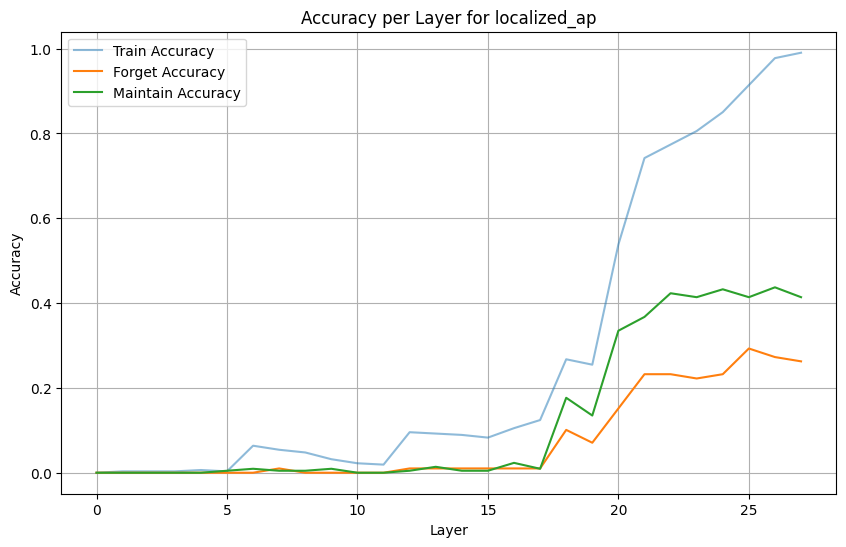

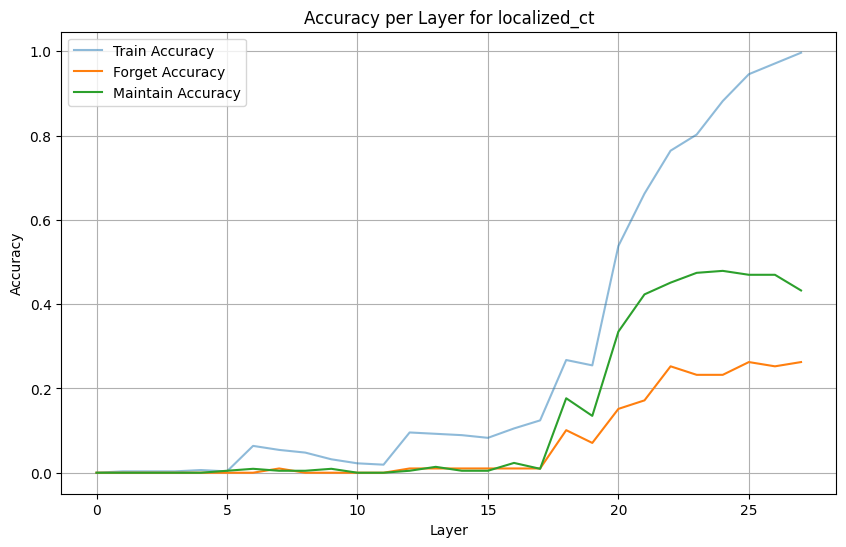

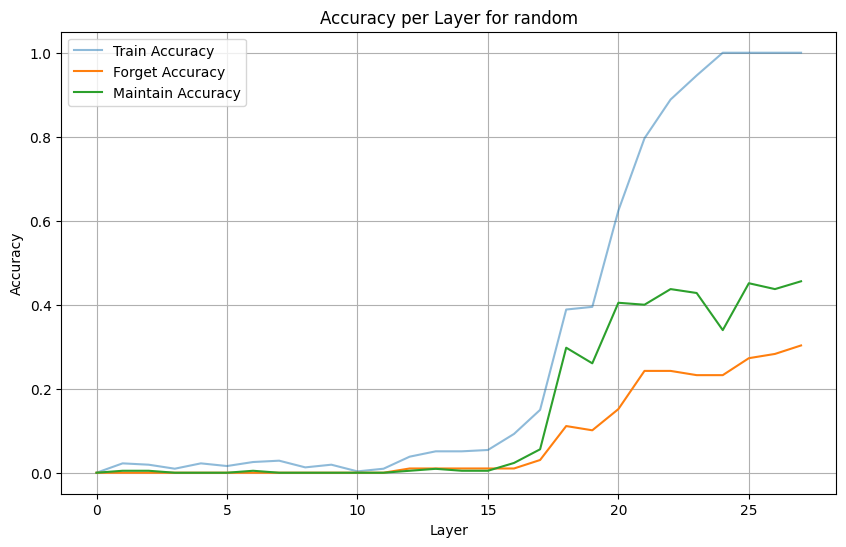

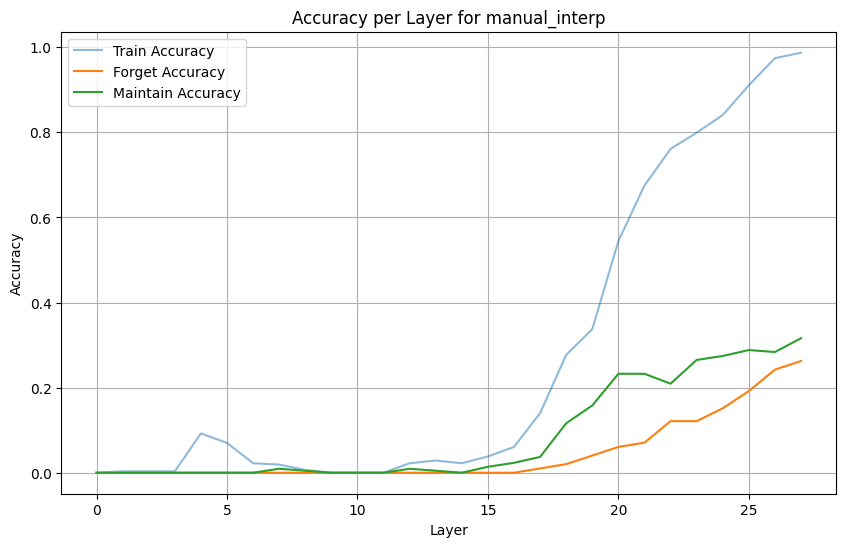

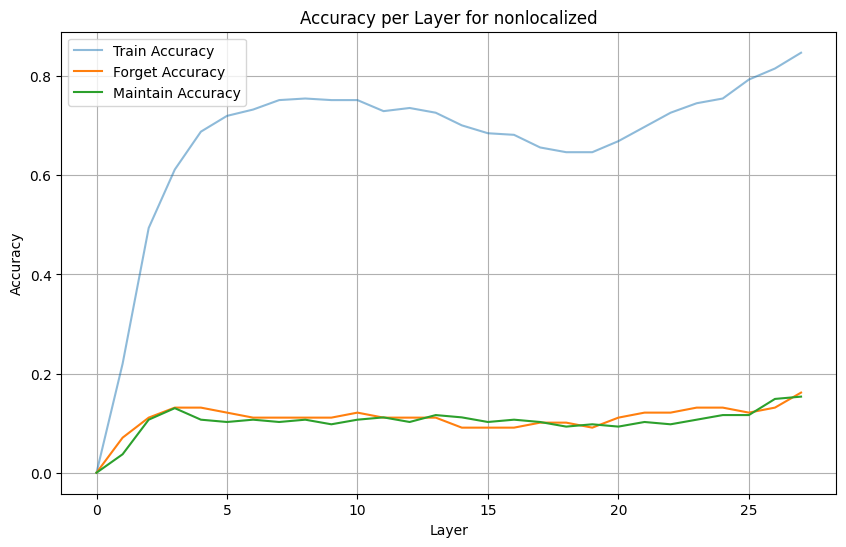

In [52]:
import matplotlib.pyplot as plt

def plot_accuracies(all_train_accs, all_forget_accs, all_maintain_accs):
    for model_name in all_train_accs.keys():
        layers = list(all_train_accs[model_name].keys())
        train_accs = [all_train_accs[model_name][layer] for layer in layers]
        forget_accs = [all_forget_accs[model_name][layer] for layer in layers]
        maintain_accs = [all_maintain_accs[model_name][layer] for layer in layers]

        plt.figure(figsize=(10, 6))
        plt.plot(layers, train_accs, label='Train Accuracy', alpha=0.5)
        plt.plot(layers, forget_accs, label='Forget Accuracy')
        plt.plot(layers, maintain_accs, label='Maintain Accuracy')
        
        plt.xlabel('Layer')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy per Layer for {model_name}')
        plt.legend()
        plt.grid(True)
        plt.show()

# Call the function to plot the accuracies
plot_accuracies(all_train_accs, all_forget_accs, all_maintain_accs)